# Using a sequential Monte Carlo model to localize sensors based on radio pings: run calculations

## Load the libraries we need

Load the third-party libraries.

In [1]:
import numpy as np
from scipy import special
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import math

Load our `smclocalize` module.

In [2]:
from smclocalize import *

## Load the ping data

In [3]:
data_numpy_path = './data/numpy/'

In [4]:
data_numpy_filename = 'ping_data'

In [5]:
ping_data = np.load(data_numpy_path + data_numpy_filename + '.npz')

In [6]:
child_entity_ids = ping_data['child_entity_ids']
material_entity_ids = ping_data['material_entity_ids']
teacher_entity_ids = ping_data['teacher_entity_ids']
area_entity_ids = ping_data['area_entity_ids']
timestamps = ping_data['timestamps']
num_timesteps = ping_data['num_timesteps']
y_discrete_t = ping_data['y_discrete_t']
y_continuous_t = ping_data['y_continuous_t']

## Define the variable structure for the model

Using the lists of entity IDs, define an instance of the `SensorVariableStructure` class. This class provides a whole bunch of variables and helper functions for working with the data.

In [7]:
variable_structure = SensorVariableStructure(child_entity_ids,
                                             material_entity_ids,
                                             teacher_entity_ids,
                                             area_entity_ids)

## Create the model

### Room geometry

Here is the rough room geometry, taken from the notes we made when we installed.

In [8]:
feet_to_meters = 12*2.54/100

In [9]:
room_size = np.array([(19.0 + 4.0/12.0 + 15.0/12.0 + 43.0 + 2.0/12.0 + 2.0)*feet_to_meters,
                      (11.0 + 9.0/12.0)*feet_to_meters])

In [10]:
room_corners = np.array([[0.0, 0.0], room_size])

### Positions of fixed sensors

Here are the rough positions of the fixed sensors, taken from the notes we made when we installed.

In [11]:
fixed_sensor_positions = np.array ([[(19.0 + 4.0/12.0 + 15.0/12.0 + 2.0)*feet_to_meters,
                                     (11.0 + 9.0/12.0 - 1.0)*feet_to_meters],
                                   [(2.0)*feet_to_meters,
                                    (11.0 + 9.0/12.0 - 1.0)*feet_to_meters],
                                   [(19.0 + 4.0/12.0 + 15.0/12.0 + 43.0 + 2.0/12.0 + 1.0)*feet_to_meters,
                                    (3.0)*feet_to_meters],
                                   [(19.0 + 4.0/12.0 + 15.0/12.0 + 15.0)*feet_to_meters,
                                    (1.0)*feet_to_meters],
                                    [(19.0 + 4.0/12.0 + 15.0/12.0 +3.0)*feet_to_meters,
                                    (3.0)*feet_to_meters]])

### Initialize the model object

Create a instance of the `SensorModel` class. This class (which is a child of the more general `SMCModel` class) provides functions which allow us to perform inference, generated simulated data, etc. It assumes particular functional forms for the initial state model, the state transition model, and the sensor response model. It does take arguments for various parameters of these models (see the code for the class), but below we use the defaults.

Set the number of particles.

In [12]:
num_particles = 10000

In [13]:
variable_structure.num_x_continuous_vars

34

In [14]:
sensor_model = SensorModel(
    variable_structure,
    room_corners,
    fixed_sensor_positions,
    num_particles)

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the real data using a particle filter

Using the helper functions provided by the `SensorModel` class, generate samples of the posterior distribution (i.e., the distribution of $\mathbf{X}$ values given the observed $\mathbf{Y}$ values). Below, we separately generate the samples for each time step to mimic the real-time use case. There is also a helper function called `generate_particle_trajectory()` which generates an entire trajectory of $\mathbf{X}$ samples given an entire trajectory of $\mathbf{Y}$ values (not shown here).

For now, we only generate the first 50 time steps to save on processing time.

In [15]:
num_timesteps_test = 50
t_test = timestamps[:num_timesteps_test]

Initialize the variables.

In [16]:
x_discrete_particles_trajectory = np.zeros(
    (num_timesteps_test, num_particles, variable_structure.num_x_discrete_vars),
    dtype = 'int')
x_continuous_particles_trajectory = np.zeros(
    (num_timesteps_test, num_particles, variable_structure.num_x_continuous_vars),
    dtype = 'float')
log_weights_trajectory = np.zeros(
    (num_timesteps_test, num_particles),
    dtype = 'float')
ancestor_indices_trajectory = np.zeros(
    (num_timesteps_test, num_particles),
    dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [17]:
x_discrete_particles_trajectory[0], x_continuous_particles_trajectory[0], log_weights_trajectory[0] = sensor_model.generate_initial_particles(
    y_discrete_t[0],
    y_continuous_t[0])

Generate the particles for all later times.

In [18]:
for t_index in range(1, num_timesteps_test):
    print('{}: {}'.format(t_index, t_test[t_index]))
    x_discrete_particles_trajectory[t_index], x_continuous_particles_trajectory[t_index], log_weights_trajectory[t_index], ancestor_indices_trajectory[t_index] = sensor_model.generate_next_particles(
        x_discrete_particles_trajectory[t_index - 1],
        x_continuous_particles_trajectory[t_index - 1],
        log_weights_trajectory[t_index - 1],
        y_discrete_t[t_index],
        y_continuous_t[t_index],
        t_test[t_index] - t_test[t_index - 1])

1: 2017-11-28T14:00:10.000000000
2: 2017-11-28T14:00:20.000000000
3: 2017-11-28T14:00:30.000000000
4: 2017-11-28T14:00:40.000000000
5: 2017-11-28T14:00:50.000000000
6: 2017-11-28T14:01:00.000000000
7: 2017-11-28T14:01:10.000000000
8: 2017-11-28T14:01:20.000000000
9: 2017-11-28T14:01:30.000000000
10: 2017-11-28T14:01:40.000000000
11: 2017-11-28T14:01:50.000000000
12: 2017-11-28T14:02:00.000000000
13: 2017-11-28T14:02:10.000000000
14: 2017-11-28T14:02:20.000000000
15: 2017-11-28T14:02:30.000000000
16: 2017-11-28T14:02:40.000000000
17: 2017-11-28T14:02:50.000000000
18: 2017-11-28T14:03:00.000000000
19: 2017-11-28T14:03:10.000000000
20: 2017-11-28T14:03:20.000000000
21: 2017-11-28T14:03:30.000000000
22: 2017-11-28T14:03:40.000000000
23: 2017-11-28T14:03:50.000000000
24: 2017-11-28T14:04:00.000000000
25: 2017-11-28T14:04:10.000000000
26: 2017-11-28T14:04:20.000000000
27: 2017-11-28T14:04:30.000000000
28: 2017-11-28T14:04:40.000000000
29: 2017-11-28T14:04:50.000000000
30: 2017-11-28T14:05:00

Calculate the maximum particle weight for each time step. When the maximum particle weight increases to 1.0, our particle filter has collapsed around a single value.

In [19]:
max_weights = np.max(np.exp(log_weights_trajectory), axis=1)

Calculate the number of particles actually sampled at each time step. If the number of particles actually sampled decreases to 1, our particle filter has collapsed around a single value.

In [20]:
num_ancestors = np.array([len(np.unique(ancestor_indices_trajectory[t_index])) for t_index in range(1, num_timesteps_test)])

Calculate the sample means and sample standard deviations of the particles at each time step.

In [21]:
x_continuous_mean_particle = np.average(
    x_continuous_particles_trajectory, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_test,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [22]:
x_continuous_squared_mean_particle = np.average(
    np.square(x_continuous_particles_trajectory), 
    axis=1,
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_test,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [23]:
x_continuous_sd_particle = np.sqrt(np.abs(x_continuous_squared_mean_particle - np.square(x_continuous_mean_particle)))

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Now we want to run the same calculation, but with simulated sensor data. This allows us to see how accurately the model can infer positions when the conditional probability distributions of the actual data match the assumptions in the model exactly.

Set the number of timesteps and initialize the variables.

In [24]:
start_time_sim = np.datetime64("2017-01-01T09:00")
time_delta_sim = np.timedelta64(10, 's')
num_timesteps_sim = 50
t_sim = np.arange(start_time_sim, start_time_sim + num_timesteps_sim*time_delta_sim, time_delta_sim)

In [25]:
x_discrete_t_sim, x_continuous_t_sim, y_discrete_t_sim, y_continuous_t_sim = sensor_model.generate_simulation_trajectory(t_sim)

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the simulated data using a particle filter

Set the number of particles and initialize variables.

In [26]:
x_discrete_particles_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles, variable_structure.num_x_discrete_vars),
    dtype = 'int')
x_continuous_particles_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles, variable_structure.num_x_continuous_vars),
    dtype = 'float')
log_weights_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles),
    dtype = 'float')
ancestor_indices_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles),
    dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [27]:
x_discrete_particles_trajectory_sim[0], x_continuous_particles_trajectory_sim[0], log_weights_trajectory_sim[0] = sensor_model.generate_initial_particles(
    y_discrete_t_sim[0],
    y_continuous_t_sim[0])

Calculate the particles for all later times.

In [28]:
for t_index in range(1, num_timesteps_sim):
    print('{}: {}'.format(t_index, t_sim[t_index]))
    x_discrete_particles_trajectory_sim[t_index], x_continuous_particles_trajectory_sim[t_index], log_weights_trajectory_sim[t_index], ancestor_indices_trajectory_sim[t_index] = sensor_model.generate_next_particles(
        x_discrete_particles_trajectory_sim[t_index - 1],
        x_continuous_particles_trajectory_sim[t_index - 1],
        log_weights_trajectory_sim[t_index - 1],
        y_discrete_t_sim[t_index],
        y_continuous_t_sim[t_index],
        t_sim[t_index] - t_sim[t_index - 1])

1: 2017-01-01T09:00:10
2: 2017-01-01T09:00:20
3: 2017-01-01T09:00:30
4: 2017-01-01T09:00:40
5: 2017-01-01T09:00:50
6: 2017-01-01T09:01:00
7: 2017-01-01T09:01:10
8: 2017-01-01T09:01:20
9: 2017-01-01T09:01:30
10: 2017-01-01T09:01:40
11: 2017-01-01T09:01:50
12: 2017-01-01T09:02:00
13: 2017-01-01T09:02:10
14: 2017-01-01T09:02:20
15: 2017-01-01T09:02:30
16: 2017-01-01T09:02:40
17: 2017-01-01T09:02:50
18: 2017-01-01T09:03:00
19: 2017-01-01T09:03:10
20: 2017-01-01T09:03:20
21: 2017-01-01T09:03:30
22: 2017-01-01T09:03:40
23: 2017-01-01T09:03:50
24: 2017-01-01T09:04:00
25: 2017-01-01T09:04:10
26: 2017-01-01T09:04:20
27: 2017-01-01T09:04:30
28: 2017-01-01T09:04:40
29: 2017-01-01T09:04:50
30: 2017-01-01T09:05:00
31: 2017-01-01T09:05:10
32: 2017-01-01T09:05:20
33: 2017-01-01T09:05:30
34: 2017-01-01T09:05:40
35: 2017-01-01T09:05:50
36: 2017-01-01T09:06:00
37: 2017-01-01T09:06:10
38: 2017-01-01T09:06:20
39: 2017-01-01T09:06:30
40: 2017-01-01T09:06:40
41: 2017-01-01T09:06:50
42: 2017-01-01T09:07:00
4

Calculate the maximum particle weight for each time step.

In [29]:
max_weights_sim = np.max(np.exp(log_weights_trajectory_sim), axis=1)

Calculate the number of particles actually sampled at each time step.

In [30]:
num_ancestors_sim = np.array([len(np.unique(ancestor_indices_trajectory_sim[t_index])) for t_index in range(1, num_timesteps_sim)])

Calculate the sample means and sample standard deviations of the particles at each time step.

In [31]:
x_continuous_mean_particle_sim = np.average(
    x_continuous_particles_trajectory_sim, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_sim,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [32]:
x_continuous_squared_mean_particle_sim = np.average(
    np.square(x_continuous_particles_trajectory_sim), 
    axis=1,
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_sim,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [33]:
x_continuous_sd_particle_sim = np.sqrt(np.abs(x_continuous_squared_mean_particle_sim - np.square(x_continuous_mean_particle_sim)))

## Explore and visualize the ping data

### Ping success rate

First, we calculate the ping success rate for each pair of sensors.

In [34]:
ping_success_rate = pd.DataFrame.from_items([
    ('y_discrete_name', variable_structure.y_discrete_names),
    ('success_rate', np.sum(y_discrete_t == 0, axis=0)/float(num_timesteps))
])

In [35]:
pd.set_option('display.max_colwidth', -1)
ping_success_rate

y_discrete_name  \
0    Status of ping from Child sensor 11060 to Child sensor 11061        
1    Status of ping from Child sensor 11060 to Child sensor 11065        
2    Status of ping from Child sensor 11060 to Child sensor 11066        
3    Status of ping from Child sensor 11060 to Child sensor 11067        
4    Status of ping from Child sensor 11060 to Child sensor 39282        
5    Status of ping from Child sensor 11060 to Child sensor 41582        
6    Status of ping from Child sensor 11060 to Child sensor 47422        
7    Status of ping from Child sensor 11060 to Child sensor 62459        
8    Status of ping from Child sensor 11060 to Material sensor 1208461   
9    Status of ping from Child sensor 11060 to Material sensor 1208463   
10   Status of ping from Child sensor 11060 to Material sensor 1208464   
11   Status of ping from Child sensor 11060 to Material sensor 1208468   
12   Status of ping from Child sensor 11060 to Material sensor 1208469   
13   Status of ping from Child sensor 11060 to Material sensor 1208471   
14   Status of ping from Child sensor 11060 to Teacher sensor 5612       
15   Status of ping from Child sensor 11060 to Teacher sensor 5613       
16   Status of ping from Child sensor 11060 to Area sensor 9             
17   Status of ping from Child sensor 11060 to Area sensor 10            
18   Status of ping from Child sensor 11060 to Area sensor 11            
19   Status of ping from Child sensor 11060 to Area sensor 12            
20   Status of ping from Child sensor 11060 to Area sensor 13            
21   Status of ping from Child sensor 11061 to Child sensor 11060        
22   Status of ping from Child sensor 11061 to Child sensor 11065        
23   Status of ping from Child sensor 11061 to Child sensor 11066        
24   Status of ping from Child sensor 11061 to Child sensor 11067        
25   Status of ping from Child sensor 11061 to Child sensor 39282        
26   Status of ping from Child sensor 11061 to Child sensor 41582        
27   Status of ping from Child sensor 11061 to Child sensor 47422        
28   Status of ping from Child sensor 11061 to Child sensor 62459        
29   Status of ping from Child sensor 11061 to Material sensor 1208461   
..                                                                 ...   
320  Status of ping from Area sensor 11 to Child sensor 11066            
321  Status of ping from Area sensor 11 to Child sensor 11067            
322  Status of ping from Area sensor 11 to Child sensor 39282            
323  Status of ping from Area sensor 11 to Child sensor 41582            
324  Status of ping from Area sensor 11 to Child sensor 47422            
325  Status of ping from Area sensor 11 to Child sensor 62459            
326  Status of ping from Area sensor 11 to Teacher sensor 5612           
327  Status of ping from Area sensor 11 to Teacher sensor 5613           
328  Status of ping from Area sensor 12 to Child sensor 11060            
329  Status of ping from Area sensor 12 to Child sensor 11061            
330  Status of ping from Area sensor 12 to Child sensor 11065            
331  Status of ping from Area sensor 12 to Child sensor 11066            
332  Status of ping from Area sensor 12 to Child sensor 11067            
333  Status of ping from Area sensor 12 to Child sensor 39282            
334  Status of ping from Area sensor 12 to Child sensor 41582            
335  Status of ping from Area sensor 12 to Child sensor 47422            
336  Status of ping from Area sensor 12 to Child sensor 62459            
337  Status of ping from Area sensor 12 to Teacher sensor 5612           
338  Status of ping from Area sensor 12 to Teacher sensor 5613           
339  Status of ping from Area sensor 13 to Child sensor 11060            
340  Status of ping from Area sensor 13 to Child sensor 11061            
341  Status of ping from Area sensor 13 to Child sensor 11065            
342  Status of ping from Area sensor 13 to Child sensor 110

It looks like most sensor pairs have a success rate below 30%. A few have no pings recorded at all. Calculate the median success rate across all pairs.

In [36]:
ping_success_rate['success_rate'].median()

0.13579387186629527

Plot a histogram.

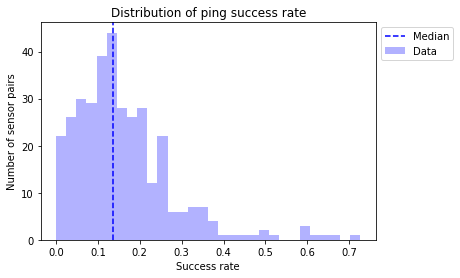

In [37]:
plt.hist(
    ping_success_rate['success_rate'],
    bins=30,
    facecolor='blue',
    alpha=0.3,
    label='Data')
plt.axvline(
    ping_success_rate['success_rate'].median(),
    linestyle='dashed',
    color='blue',
    label='Median')
plt.xlabel('Success rate')
plt.ylabel('Number of sensor pairs')
plt.title('Distribution of ping success rate')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

We don't know how this lines up with distance because we don't have ground truth distance data, but we might guess that the median success rate (about 13.5%) is typical for the presumed median distance between sensors (about 10 meters, roughly half the length of the room).

### Signal strength

Now we want to look at the distribution of measured RSSI values, but we need to take care to remove the zero values where no ping was received.

In [38]:
measured_rssi_values = y_continuous_t[y_continuous_t != 0.0]

Calculate the median observed RSSI value.

In [39]:
np.median(measured_rssi_values)

-80.0

Plot a histogram.

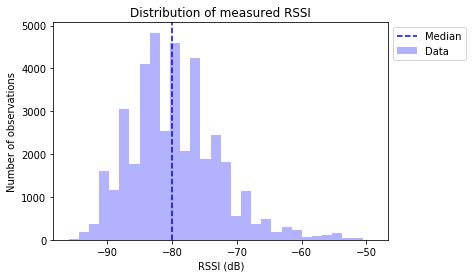

In [40]:
plt.hist(
    measured_rssi_values,
    bins=30,
    facecolor='blue',
    alpha=0.3,
    label='Data')
plt.axvline(
    np.median(measured_rssi_values),
    linestyle='dashed',
    color='blue',
    label='Median')
plt.xlabel('RSSI (dB)')
plt.ylabel('Number of observations')
plt.title('Distribution of measured RSSI')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Again, we don't know how this lines up with distance because we don't have ground truth distance data, but we might guess that the median measured RSSI value (about -80 dB) is typical for the presumed median distance between sensors (about 10 meters, roughly half the length of the room).

## Explore and visualize model inputs

Generate 1,000 samples of `x_initial_sample()` and check that they have the properties we expect.

In [41]:
x_discrete_initial_samples, x_continuous_initial_samples = sensor_model.x_initial_sample_test(1000)

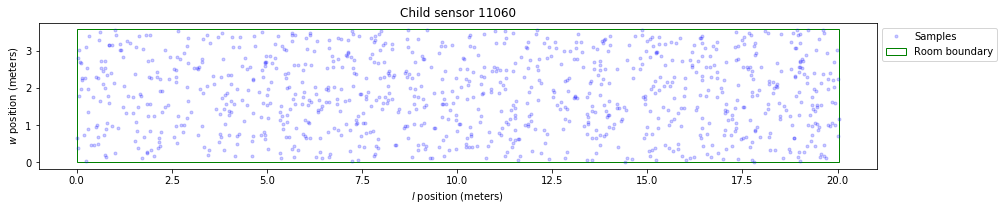

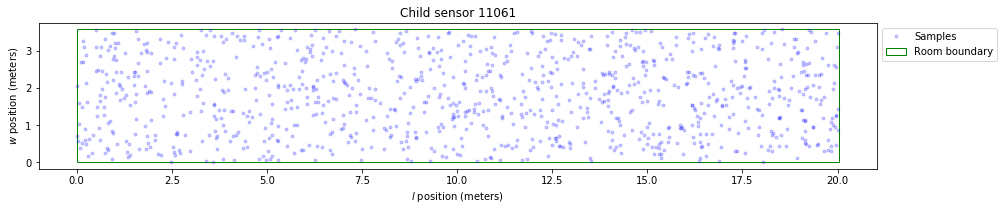

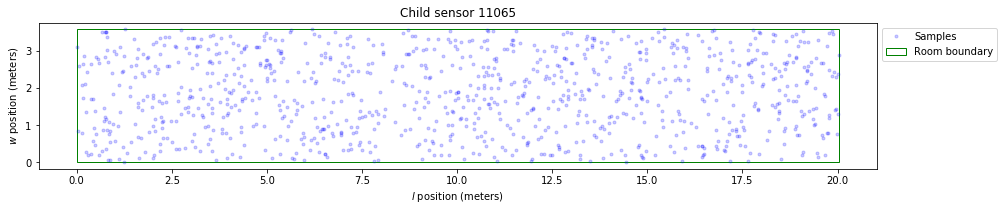

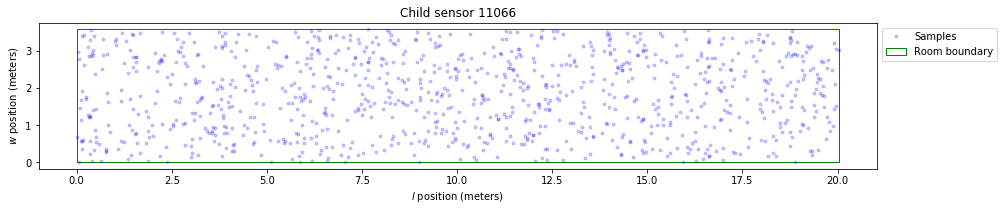

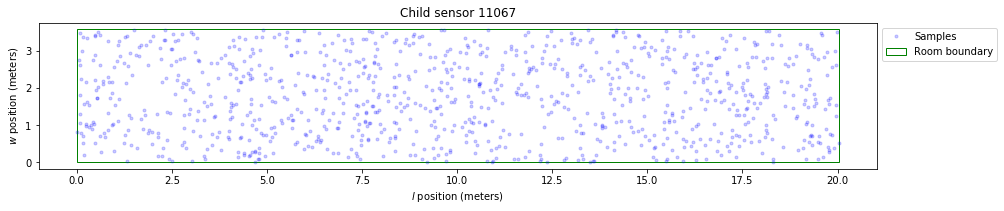

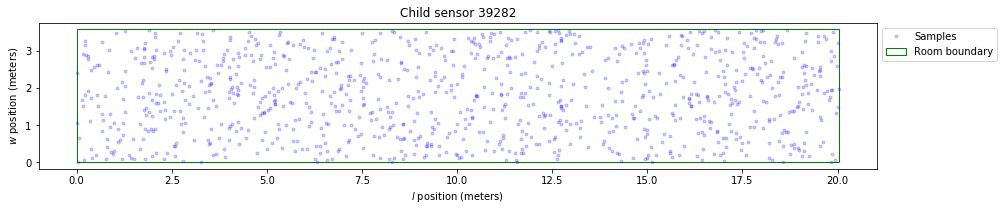

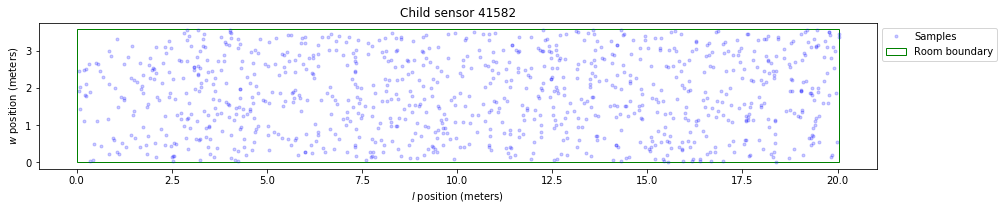

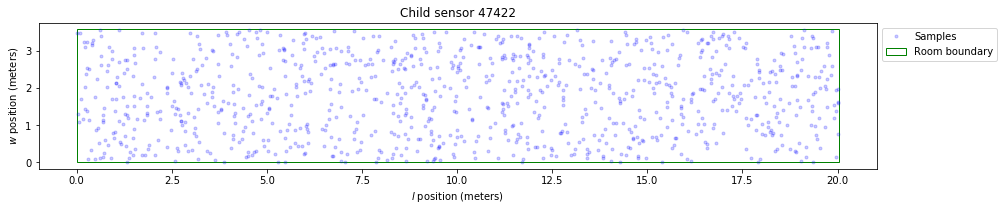

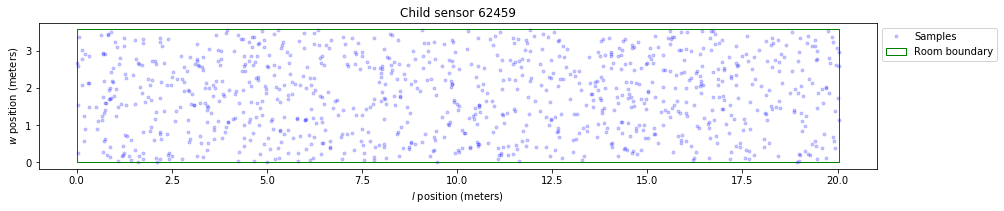

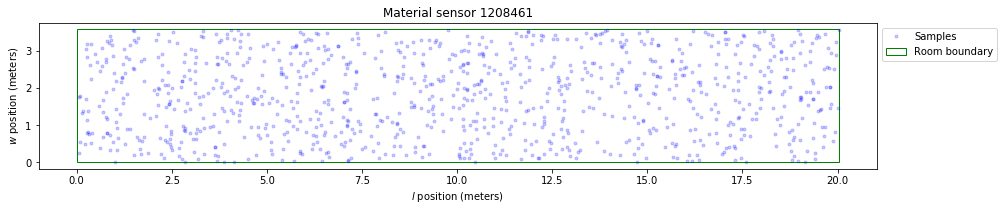

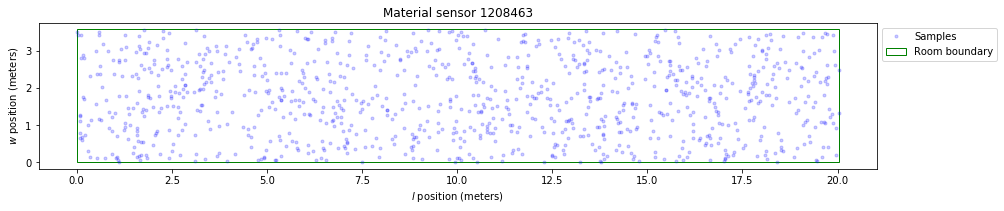

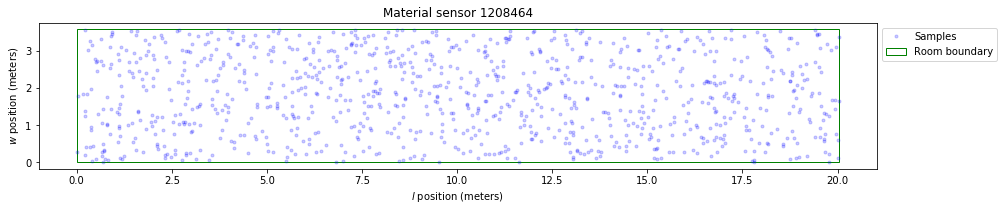

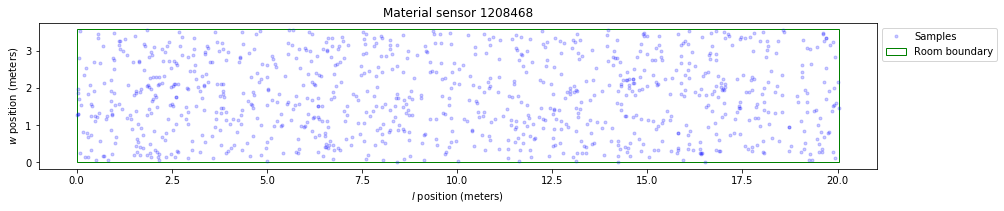

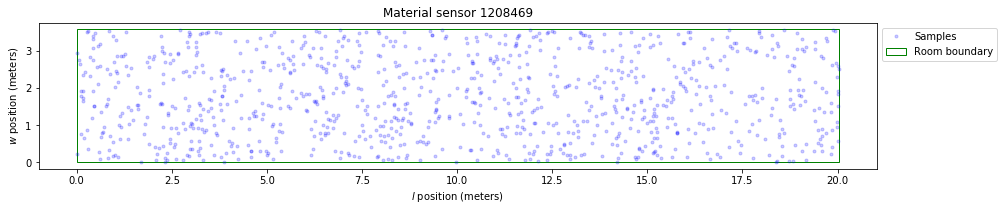

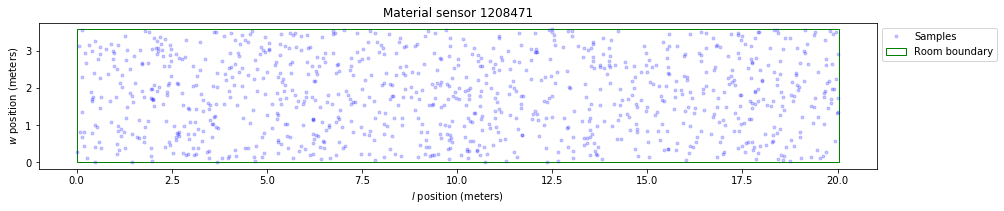

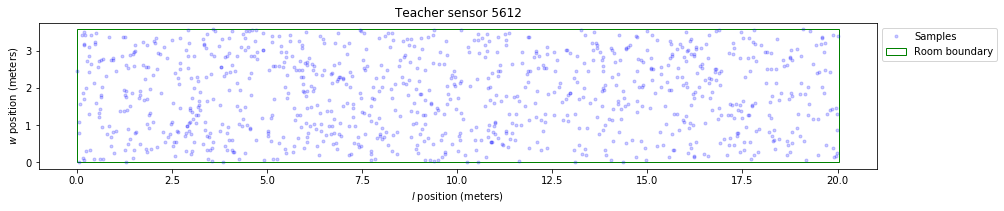

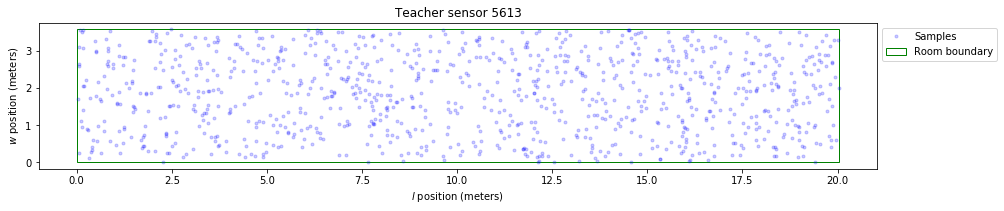

In [42]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(variable_structure.num_moving_sensors):
    plt.plot(
        x_continuous_initial_samples[:,sensor_index*2],
        x_continuous_initial_samples[:,sensor_index*2 + 1],
        'b.',
        alpha = 0.2,
        label="Samples")
    plt.title(variable_structure.sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(variable_structure.dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(variable_structure.dimension_names[1]))
    ax=plt.gca()
    ax.add_patch(
        patches.Rectangle(
            (0,0),
            room_size[0],
            room_size[1],
            fill=False,
            color='green',
            label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

Choose an arbitrary test value for $\mathbf{X}$, drawn from the initial distribution, that we can use to test the various functions below.

In [43]:
test_x_discrete_value, test_x_continuous_value = sensor_model.x_initial_sample_test()

Generate 1,000 samples from `x_bar_x_previous_sample()` (using our test value for $\mathbf{X}_{t-1}$) to make sure they have the properties we expect.

In [44]:
x_discrete_bar_x_previous_samples, x_continuous_bar_x_previous_samples = sensor_model.x_bar_x_previous_sample_test(
    np.array([]),
    np.tile(test_x_continuous_value, (1000,1)),
    np.timedelta64(10, 's'))

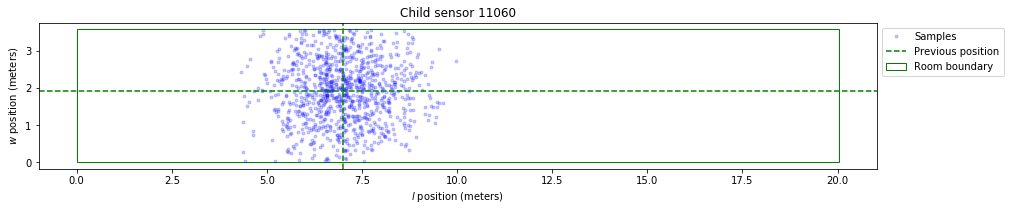

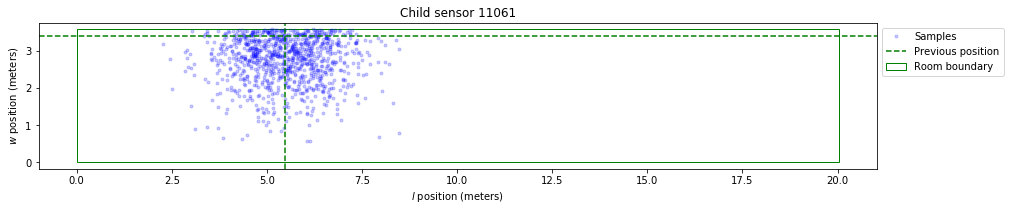

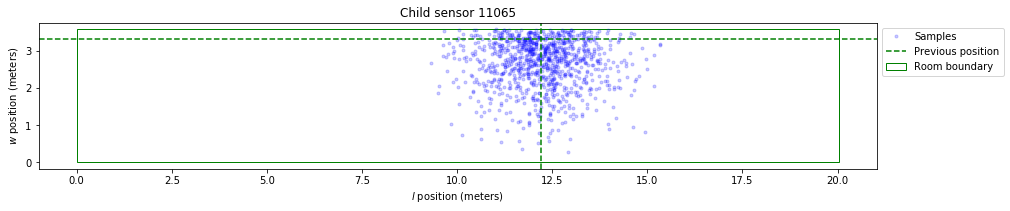

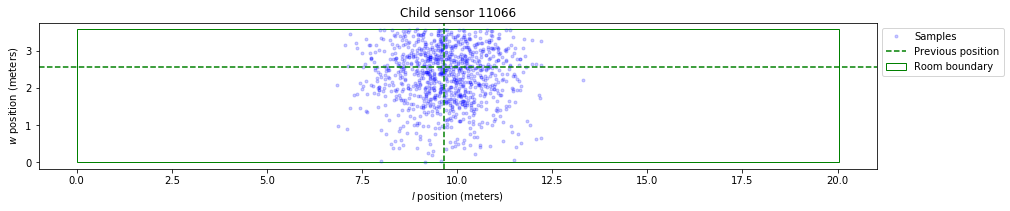

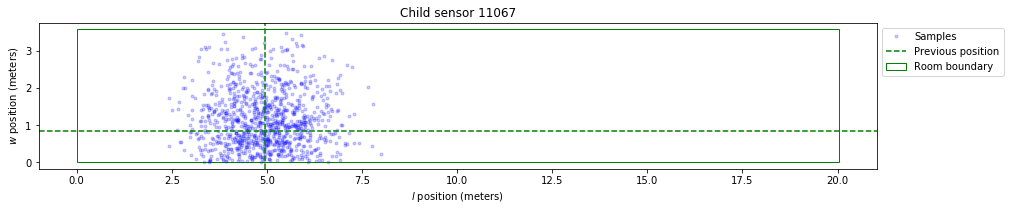

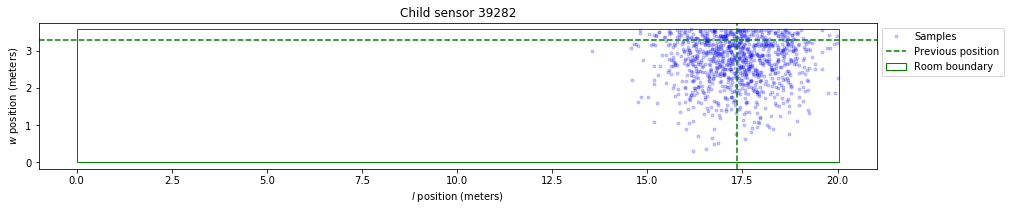

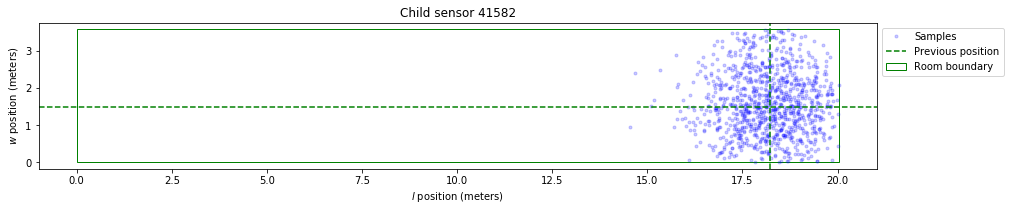

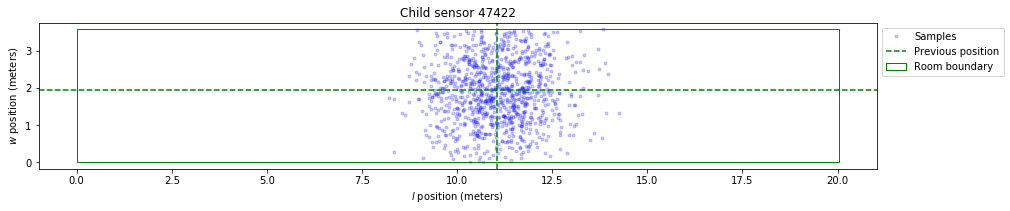

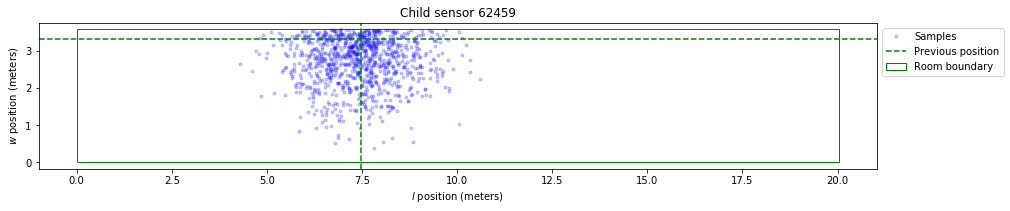

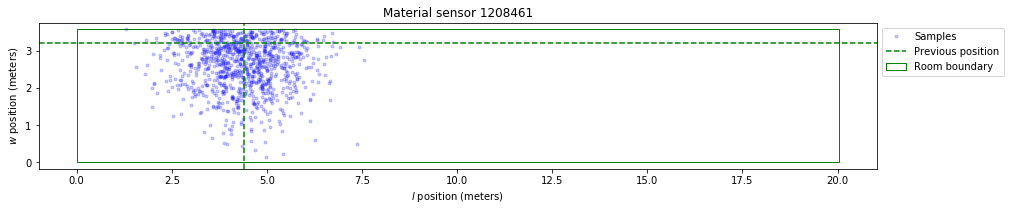

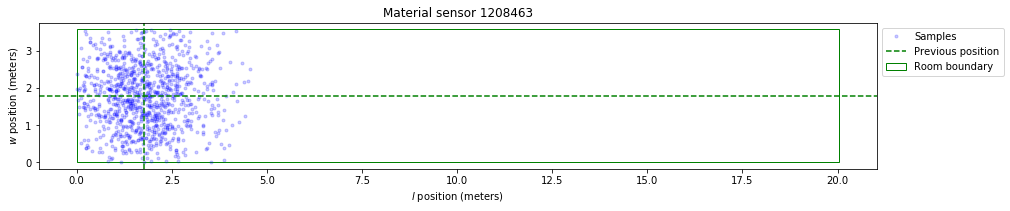

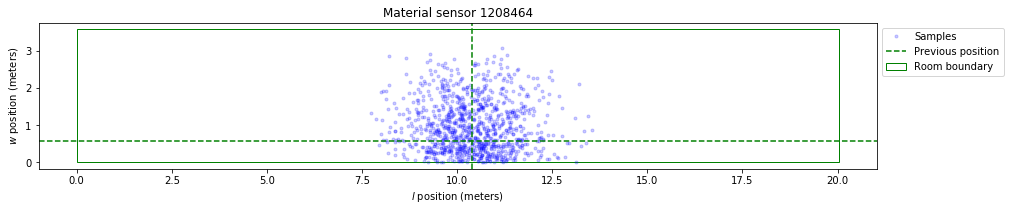

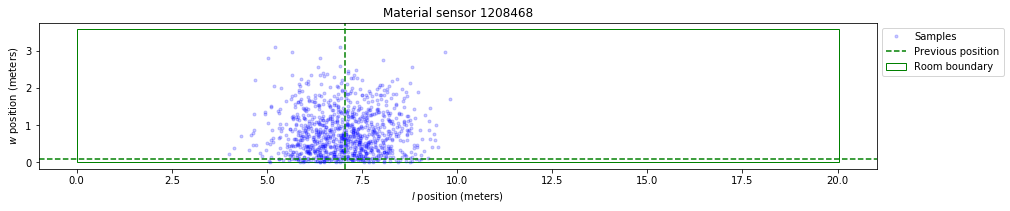

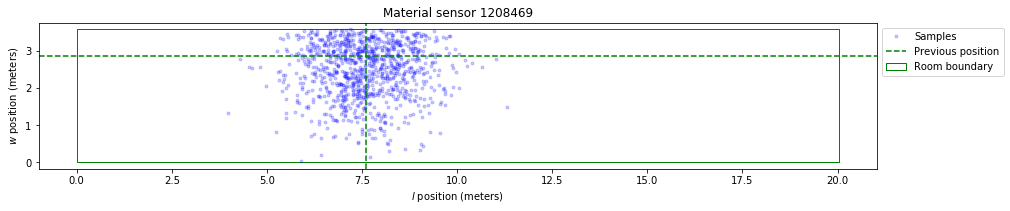

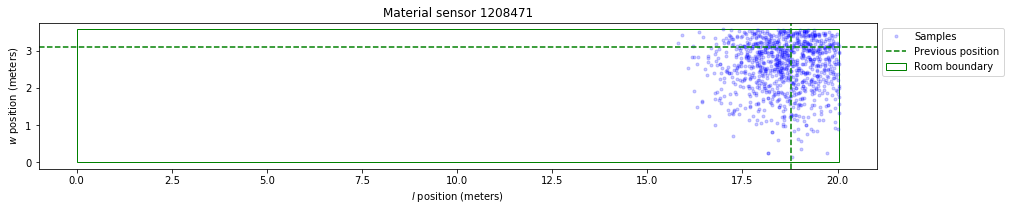

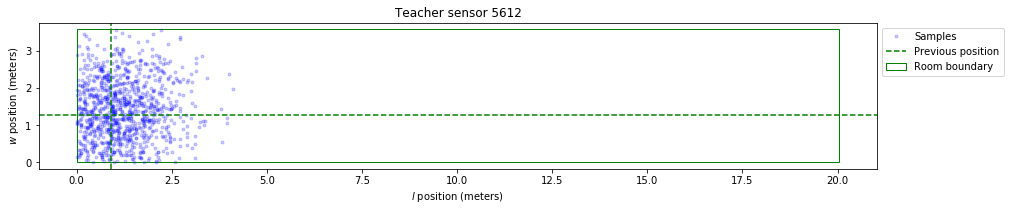

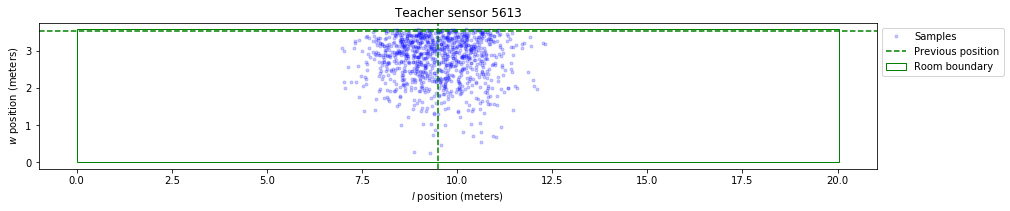

In [45]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(variable_structure.num_moving_sensors):
    plt.plot(
        x_continuous_bar_x_previous_samples[:,sensor_index*2],
        x_continuous_bar_x_previous_samples[:,sensor_index*2 + 1],
        'b.',
        alpha=0.2,
        label='Samples')
    plt.title(variable_structure.sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(variable_structure.dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(variable_structure.dimension_names[1]))
    plt.axvline(
        x=test_x_continuous_value[sensor_index*2],
        linestyle='dashed',
        color='green',
        label='Previous position')
    plt.axhline(y=test_x_continuous_value[sensor_index*2 + 1], linestyle='dashed', color='green')
    ax=plt.gca()
    ax.add_patch(
        patches.Rectangle(
            (0,0),
            room_size[0],
            room_size[1],
            fill=False,
            color='green',
            label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

In [46]:
y_discrete_bar_x_samples, y_continuous_bar_x_samples = sensor_model.y_bar_x_sample_test(
    np.tile(test_x_discrete_value, (10000,1)),
    np.tile(test_x_continuous_value, (10000,1)))

In [47]:
distances_test_x_continuous_value = sensor_model.distances_test(test_x_continuous_value)

Plot the results for 10 randomly chosen discrete $\mathbf{Y}$ variables.

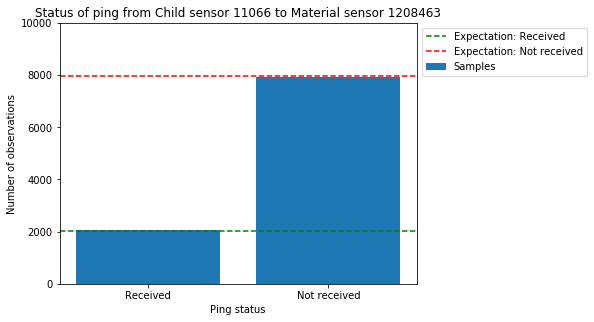

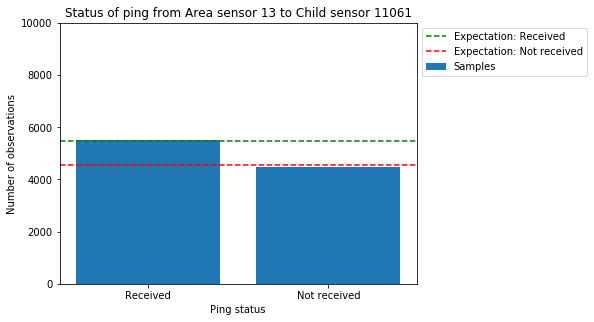

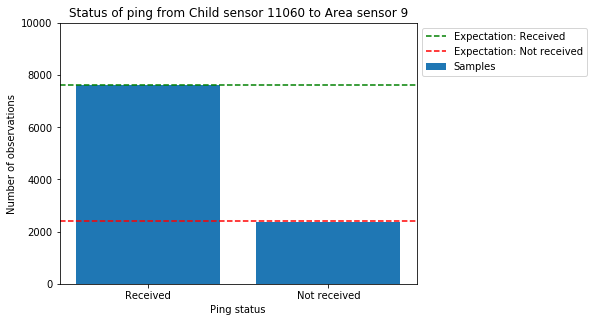

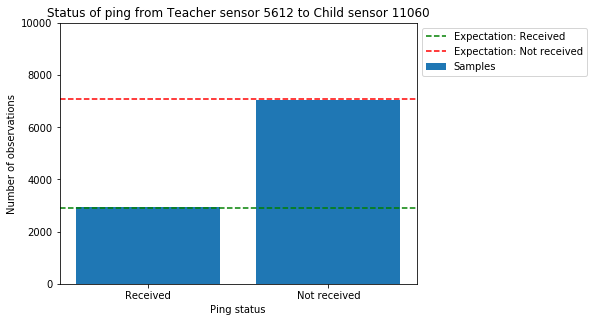

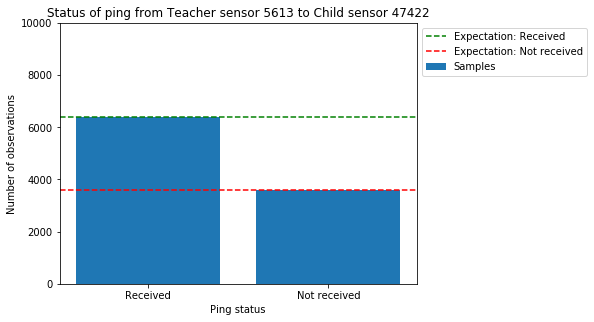

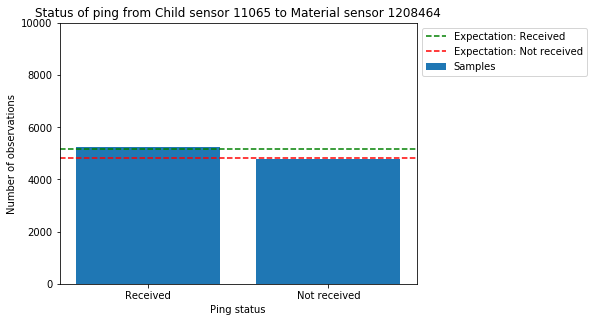

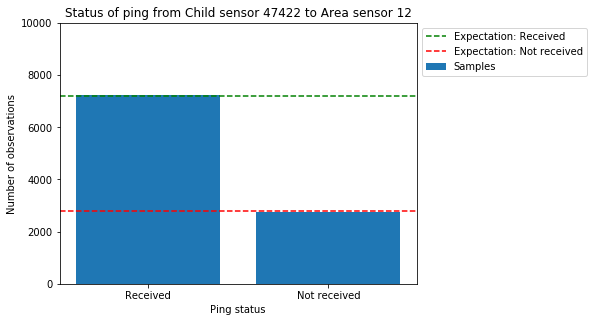

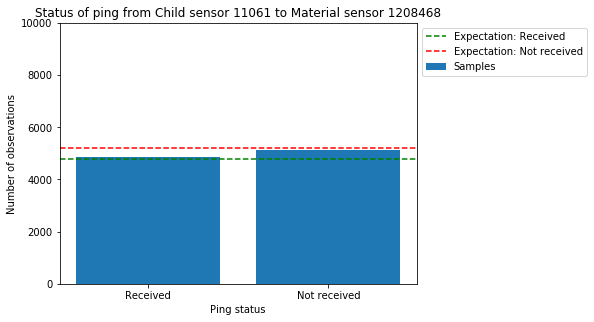

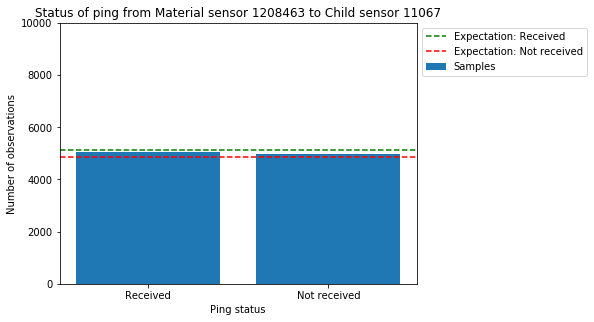

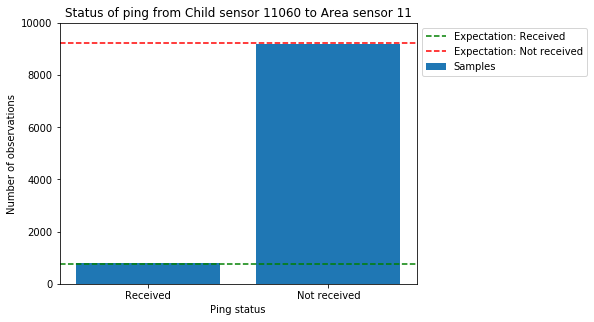

In [48]:
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    plt.bar(
        range(variable_structure.num_ping_statuses),
        np.bincount(y_discrete_bar_x_samples[:,y_discrete_var_index]),
        label='Samples')
    for ping_status_index in range(variable_structure.num_ping_statuses):
        plt.axhline(
            y=sensor_model.ping_success_probabilities_array_test(distances_test_x_continuous_value[y_discrete_var_index])[ping_status_index]*10000,
            linestyle='dashed',
            color=['green', 'red'][ping_status_index],
            label='Expectation: {}'.format(variable_structure.ping_status_names[ping_status_index]))
    plt.xticks(range(variable_structure.num_ping_statuses), variable_structure.ping_status_names)
    plt.xlabel('Ping status')
    plt.ylabel('Number of observations')
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.ylim(0, 10000)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Plot these samples for 10 randomly chosen continuous $\mathbf{Y}$ variables.

c:\users\tcqui\dropbox\wildflower\sensors\data_analysis\sensor_localization\venv\lib\site-packages\scipy\stats\_continuous_distns.py:5374: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


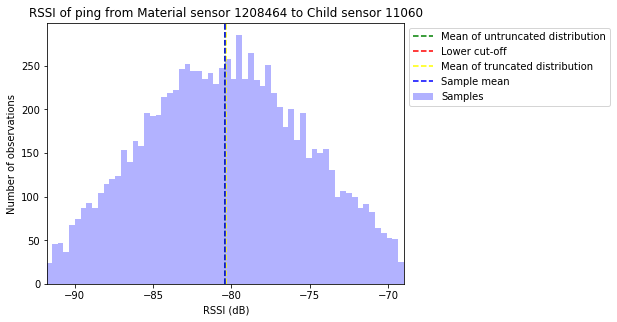

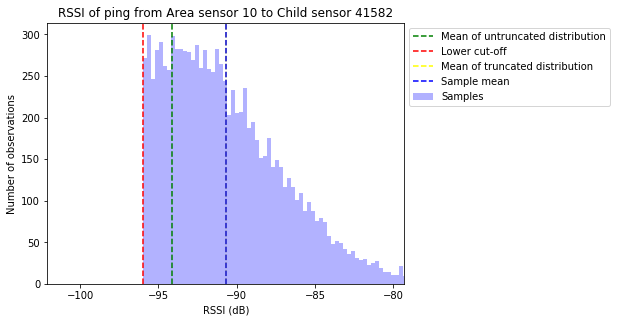

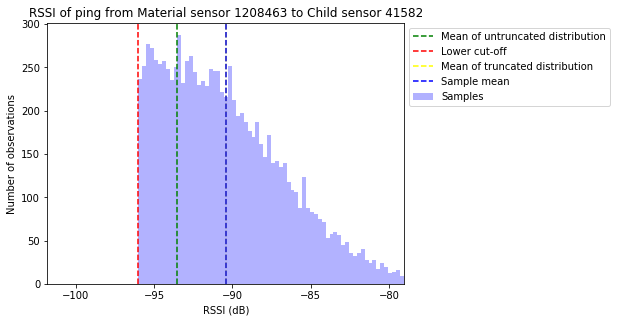

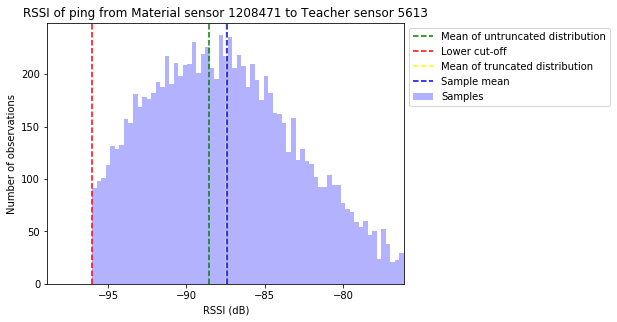

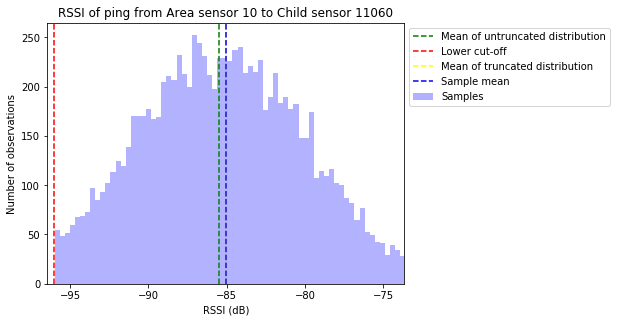

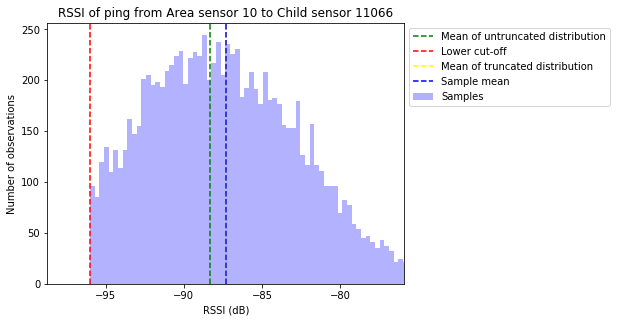

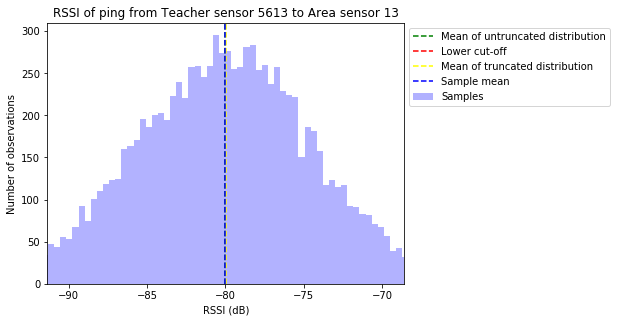

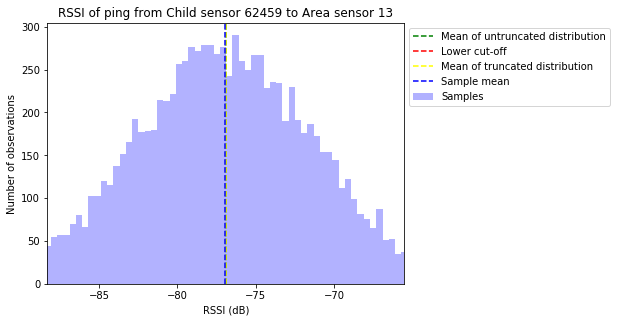

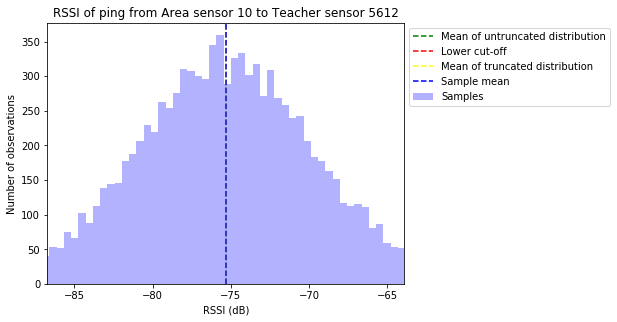

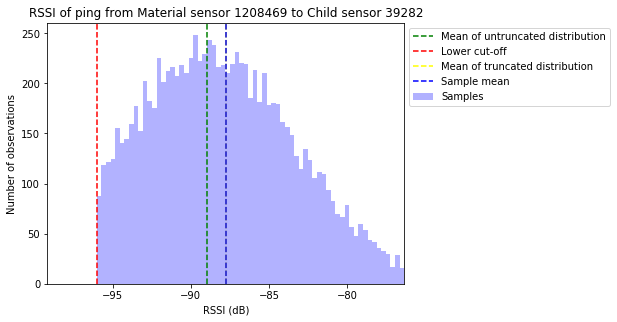

In [49]:
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    plt.hist(
        y_continuous_bar_x_samples[:,y_continuous_var_index],
        bins=100,
        facecolor='blue',
        alpha=0.3,
        label='Samples')
    plt.axvline(
        x=sensor_model.rssi_untruncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='green',
        label='Mean of untruncated distribution')
    plt.axvline(
        sensor_model.lower_rssi_cutoff,
        linestyle='dashed',
        color='red',
        label='Lower cut-off')
    plt.axvline(
        x=sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='yellow',
        label='Mean of truncated distribution')
    plt.axvline(
        np.mean(y_continuous_bar_x_samples[:,y_continuous_var_index]),
        linestyle='dashed',
        color='blue',
        label='Sample mean')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Number of observations')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlim(
        sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]) - 2*sensor_model.rssi_untruncated_std_dev,
        sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]) + 2*sensor_model.rssi_untruncated_std_dev)
    plt.show()

Using our test value for $\mathbf{X}$, plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on each sensor reading (holding the values of all of the other sensor readings fixed), to make sure it has the shape we expect. First we plot the dependence on the discrete sensor variables for 10 randomly chosen variables.

c:\users\tcqui\dropbox\wildflower\sensors\data_analysis\sensor_localization\venv\lib\site-packages\scipy\stats\_continuous_distns.py:5374: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


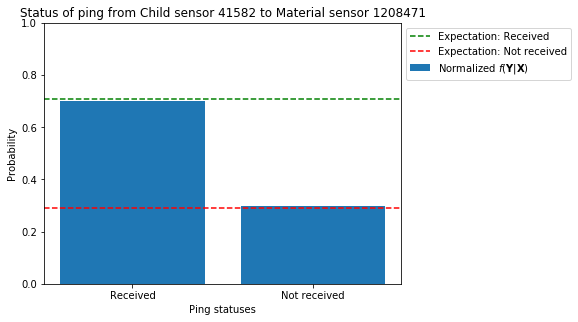

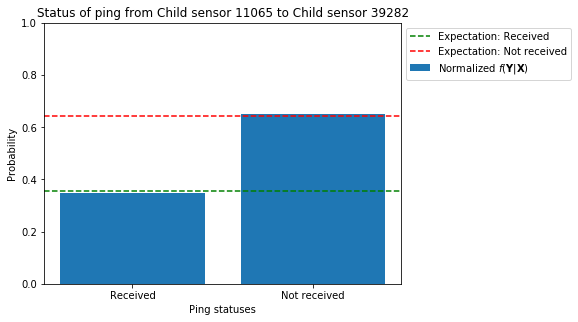

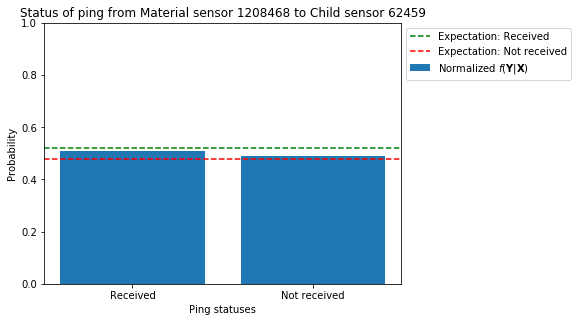

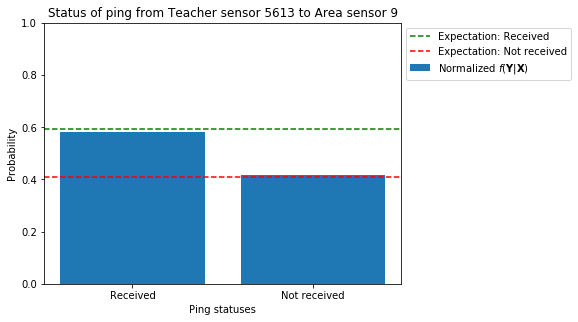

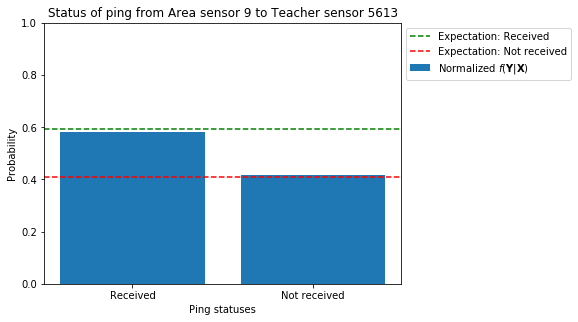

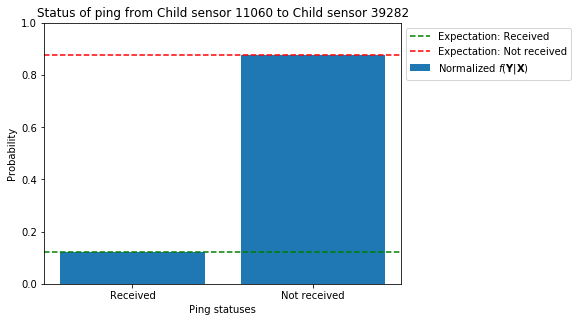

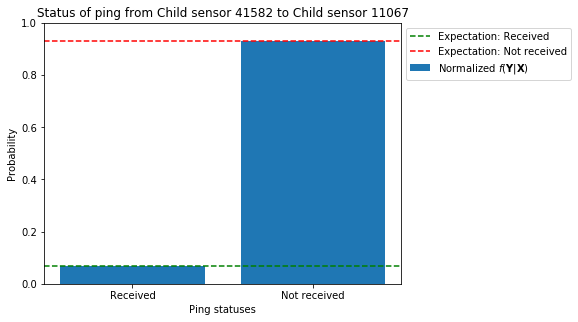

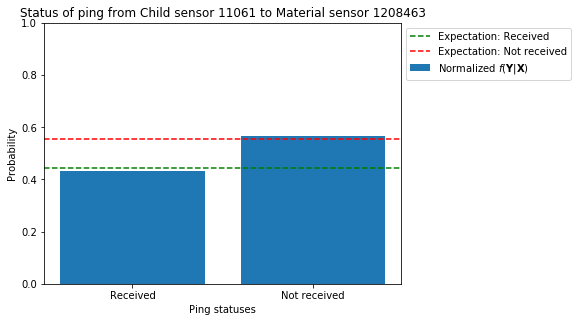

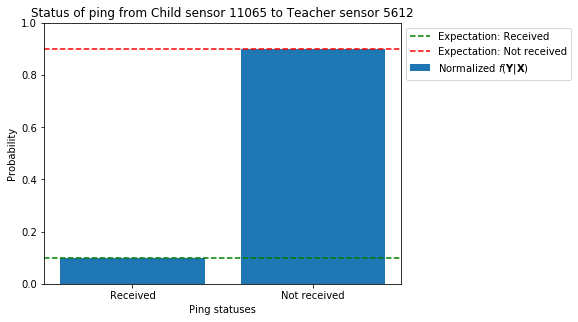

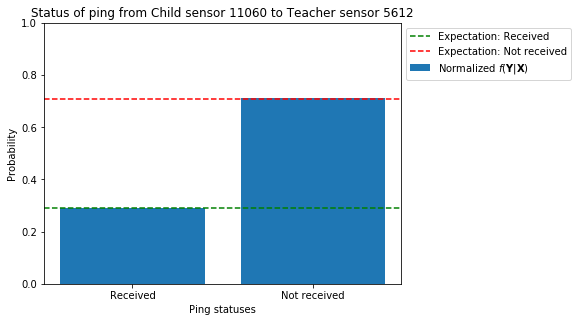

In [50]:
num_rssi_test_values = 100
mean_rssi_values = sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value)
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    log_probability_range = np.zeros(2, dtype='float')
    log_probability_density_range = np.zeros(num_rssi_test_values, dtype='float')
    test_x_discrete_values = np.tile(test_x_discrete_value, (num_rssi_test_values, 1))
    test_x_continuous_values = np.tile(test_x_continuous_value, (num_rssi_test_values, 1))
    test_y_discrete_values = np.tile(np.repeat(0, variable_structure.num_y_discrete_vars), (num_rssi_test_values, 1))
    rssi_range=np.linspace(
        mean_rssi_values[y_discrete_var_index] - 2*sensor_model.rssi_untruncated_std_dev,
        mean_rssi_values[y_discrete_var_index] + 2*sensor_model.rssi_untruncated_std_dev,
        num_rssi_test_values)
    test_y_continuous_values = np.tile(mean_rssi_values, (num_rssi_test_values, 1))
    for rssi_index in range(num_rssi_test_values):
        test_y_continuous_values[rssi_index, y_discrete_var_index] = rssi_range[rssi_index]
    log_probability_density_range = sensor_model.y_bar_x_log_pdf_test(
        test_x_discrete_values,
        test_x_continuous_values,
        test_y_discrete_values,
        test_y_continuous_values)
    log_probability_range[0] = special.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0])
    test_y_discrete_value = np.repeat(0, variable_structure.num_y_discrete_vars)
    test_y_discrete_value[y_discrete_var_index] = 1
    test_y_continuous_value = mean_rssi_values
    log_probability_range[1] = sensor_model.y_bar_x_log_pdf_test(
        test_x_discrete_value,
        test_x_continuous_value,
        test_y_discrete_value,
        test_y_continuous_value)
    log_probability_range = log_probability_range - special.logsumexp(log_probability_range)
    plt.bar(
        range(variable_structure.num_ping_statuses),
        np.exp(log_probability_range),
        label='Normalized $f(\mathbf{Y}|\mathbf{X})$')
    for ping_status_index in range(variable_structure.num_ping_statuses):
        plt.axhline(
            y=sensor_model.ping_success_probabilities_array_test(distances_test_x_continuous_value[y_discrete_var_index])[ping_status_index],
            linestyle='dashed',
            color=['green', 'red'][ping_status_index],
            label='Expectation: {}'.format(variable_structure.ping_status_names[ping_status_index]))
    plt.xticks(range(variable_structure.num_ping_statuses), variable_structure.ping_status_names)
    plt.ylim(0,1)
    plt.xlabel('Ping statuses')
    plt.ylabel('Probability')
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Now we plot the dependence on the continuous sensor variables for 10 randomly chosen variables.

c:\users\tcqui\dropbox\wildflower\sensors\data_analysis\sensor_localization\venv\lib\site-packages\scipy\stats\_continuous_distns.py:5374: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


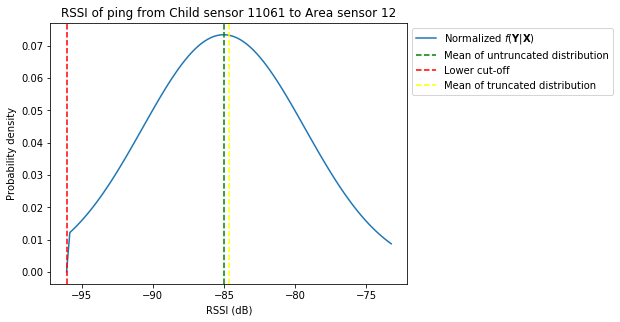

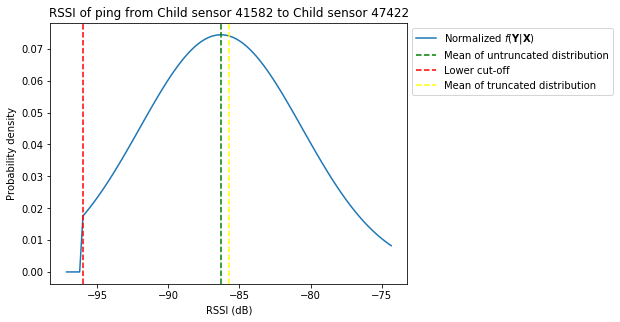

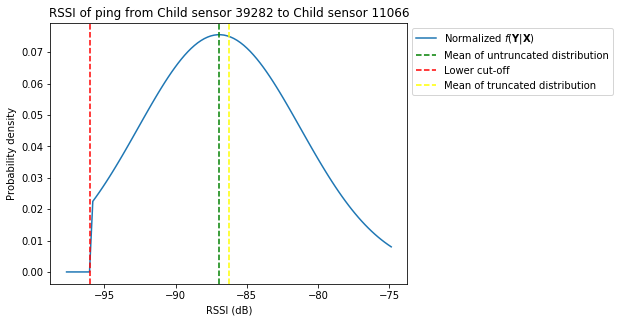

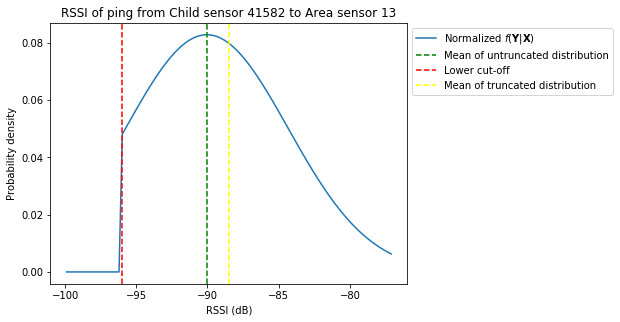

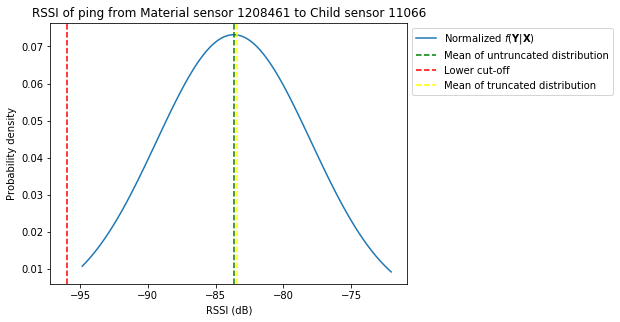

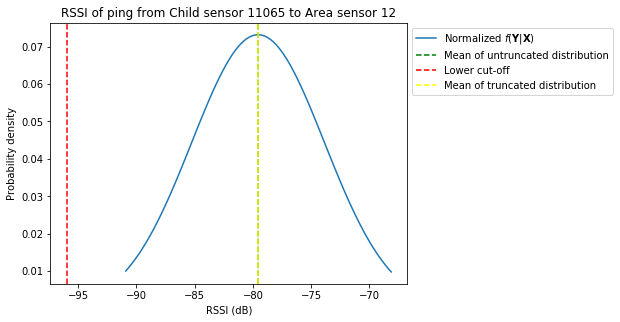

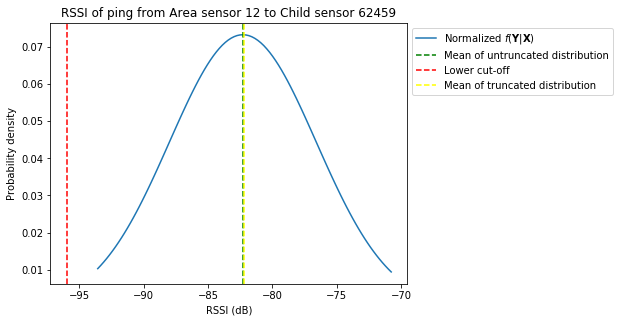

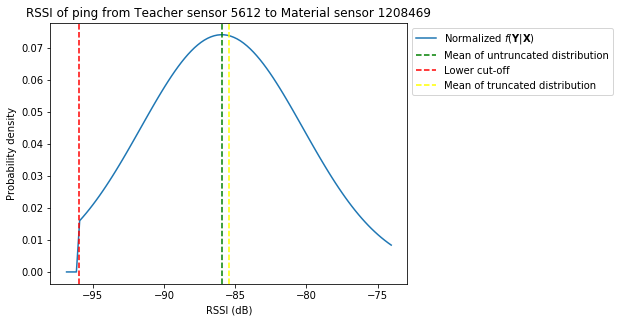

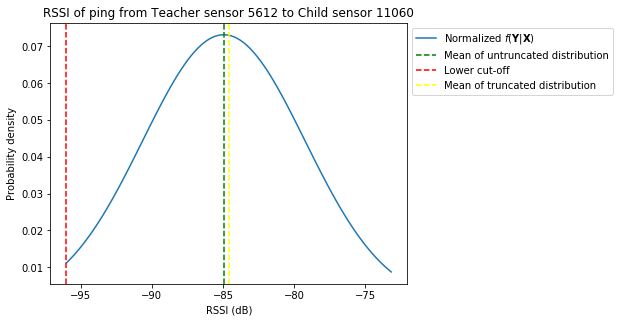

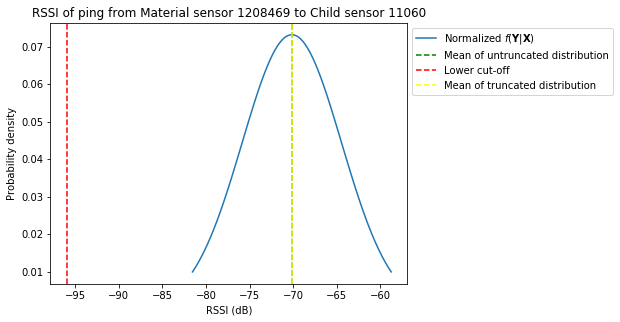

In [51]:
num_rssi_test_values = 100
mean_rssi_values = sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value)
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    log_probability_density_range = np.zeros(100, dtype='float')
    test_x_discrete_values = np.tile(test_x_discrete_value, (num_rssi_test_values, 1))
    test_x_continuous_values = np.tile(test_x_continuous_value, (num_rssi_test_values, 1))
    test_y_discrete_values = np.tile(np.repeat(0, variable_structure.num_y_discrete_vars), (num_rssi_test_values, 1))
    test_y_continuous_values = np.tile(mean_rssi_values, (num_rssi_test_values, 1))
    rssi_range=np.linspace(
        mean_rssi_values[y_continuous_var_index] - 2*sensor_model.rssi_untruncated_std_dev,
        mean_rssi_values[y_continuous_var_index] + 2*sensor_model.rssi_untruncated_std_dev,
        num_rssi_test_values)
    for rssi_index in range(num_rssi_test_values):
        test_y_continuous_values[rssi_index, y_continuous_var_index] = rssi_range[rssi_index]
    log_probability_density_range = sensor_model.y_bar_x_log_pdf_test(
        test_x_discrete_values,
        test_x_continuous_values,
        test_y_discrete_values,
        test_y_continuous_values)
    log_probability_density_range = log_probability_density_range - (special.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0]))
    plt.plot(rssi_range, np.exp(log_probability_density_range), label='Normalized $f(\mathbf{Y} | \mathbf{X})$')
    plt.axvline(
        x=sensor_model.rssi_untruncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='green',
        label='Mean of untruncated distribution')
    plt.axvline(
        sensor_model.lower_rssi_cutoff,
        linestyle='dashed',
        color='red',
        label='Lower cut-off')
    plt.axvline(
        x=sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='yellow',
        label='Mean of truncated distribution')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Probability density')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Explore and visualize model outputs

### Real data

Plot the maximum particle weight for each time step. Again, when this reaches 1.0, the particle filter has collapsed around a single $\mathbf{X}$ value.

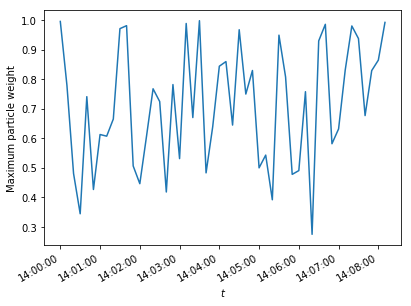

In [52]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test[:num_timesteps_test], max_weights)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Maximum particle weight')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the number of sampled ancestor particles at each time step. Again, when this shrinks to 1, the particle filter has collapsed around a single $\mathbf{X}$ value.

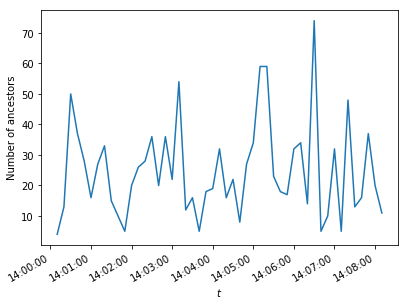

In [53]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test[1:num_timesteps_test], num_ancestors)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of ancestors')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample means of the particles. This represents our best guess at the positions of the moving sensors.

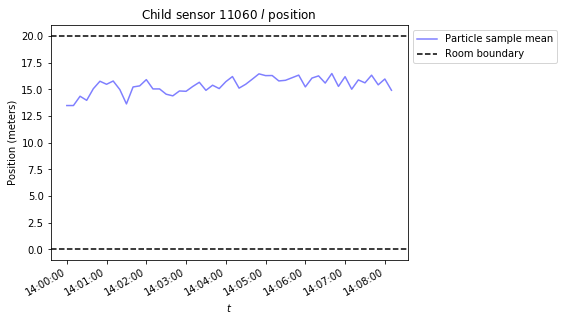

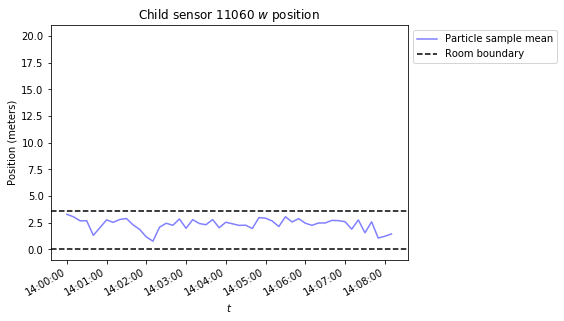

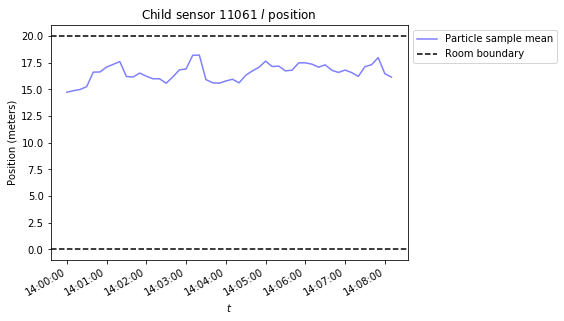

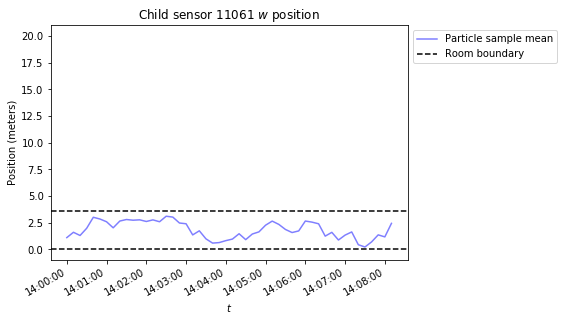

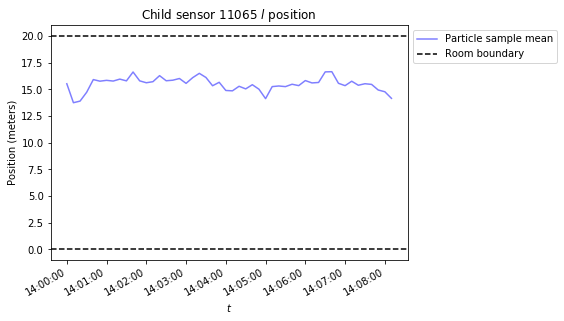

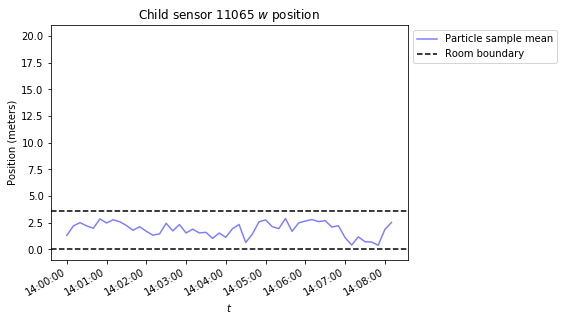

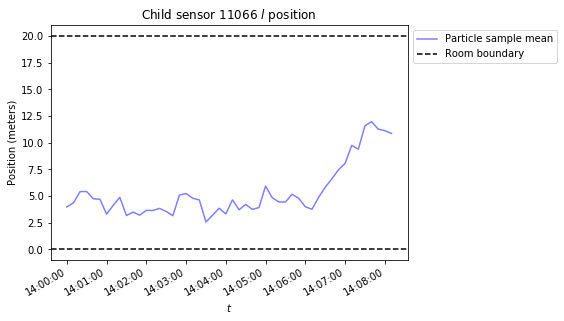

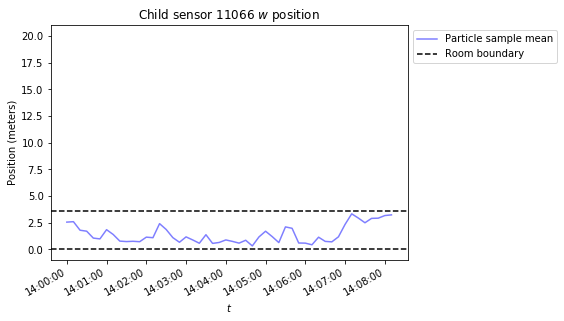

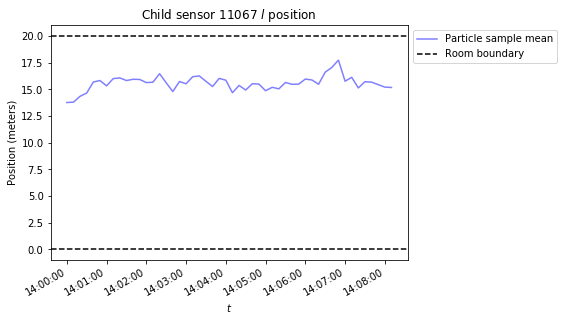

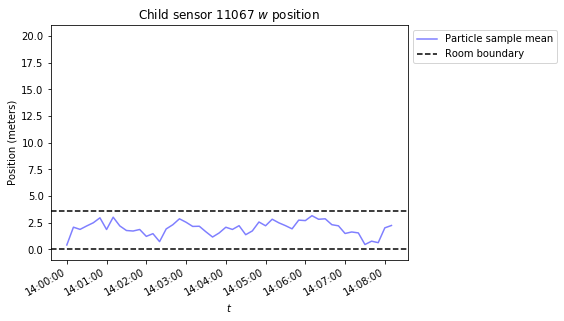

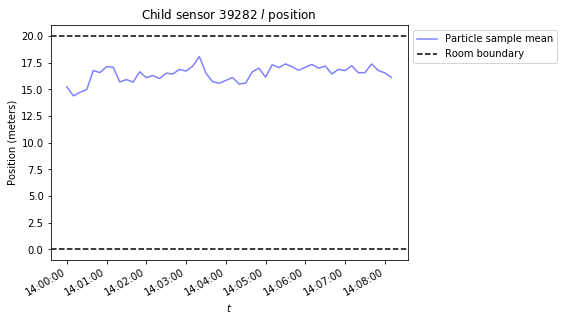

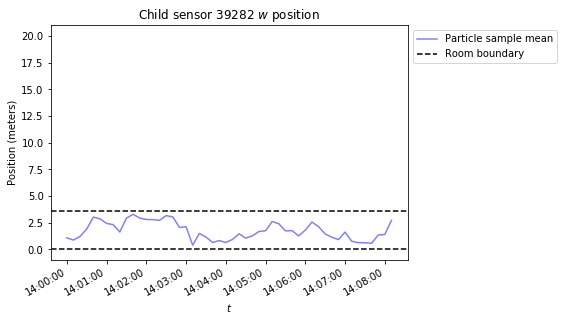

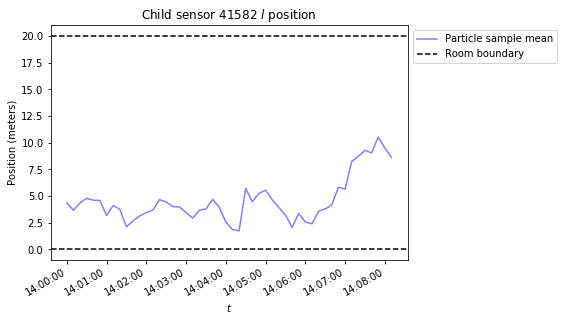

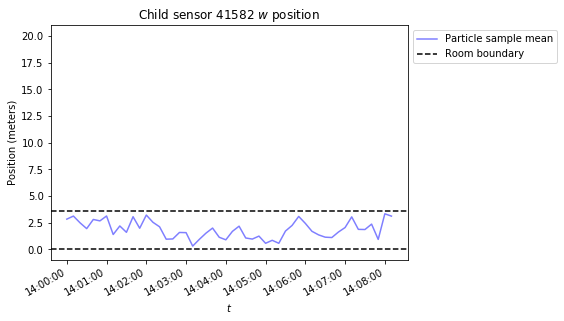

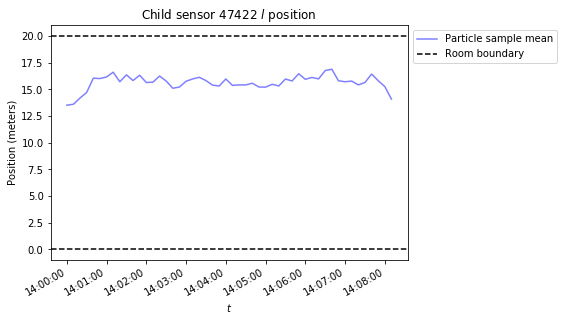

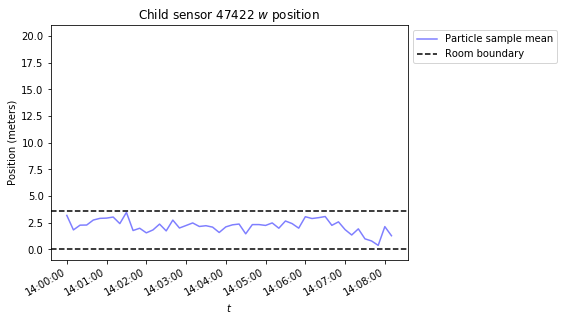

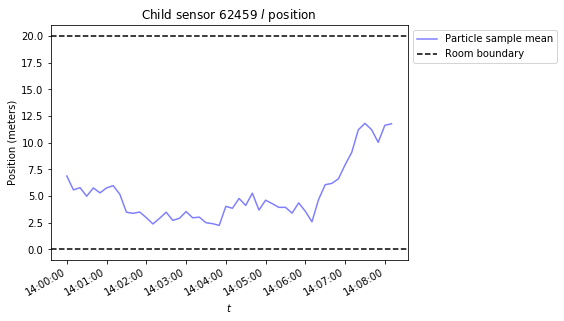

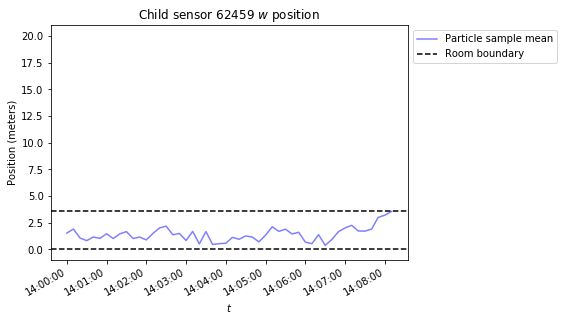

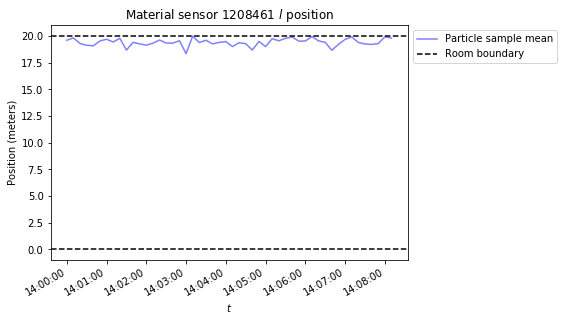

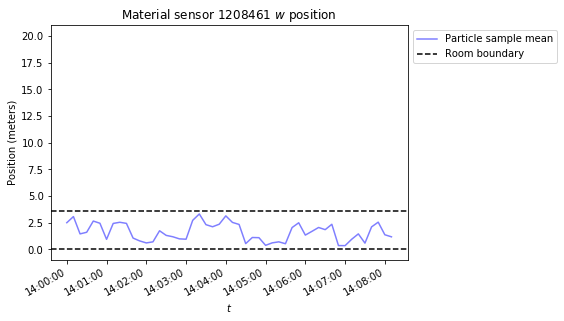

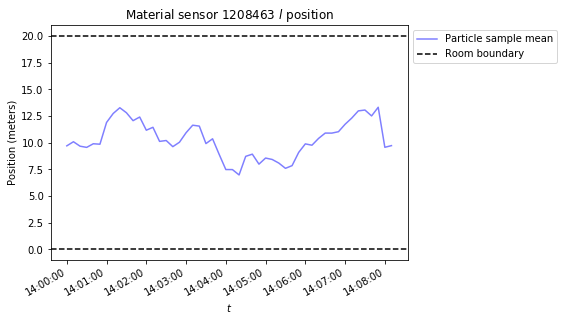

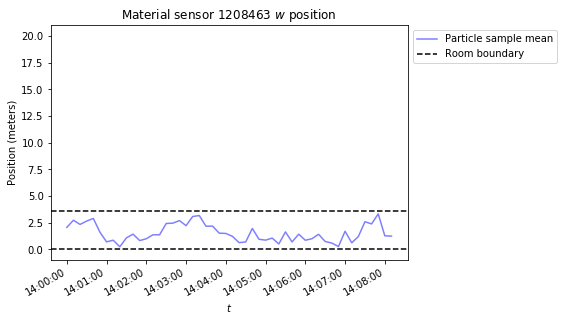

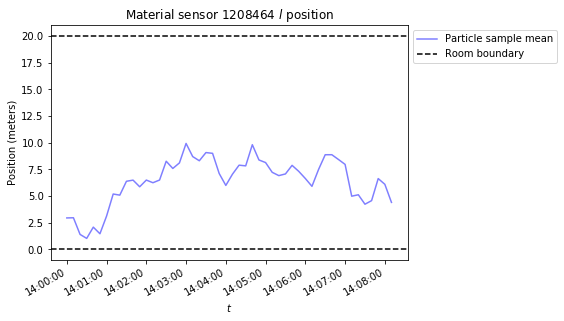

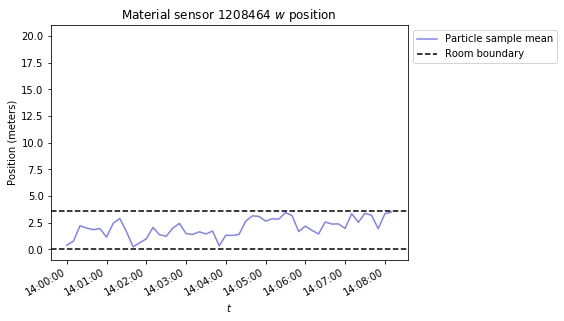

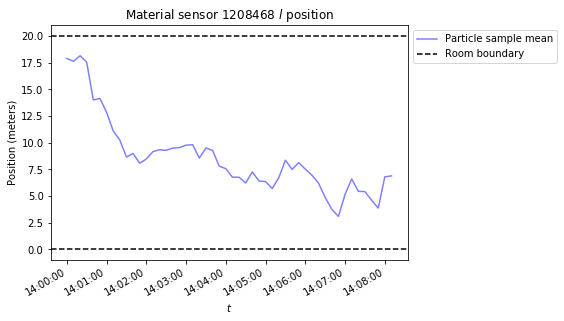

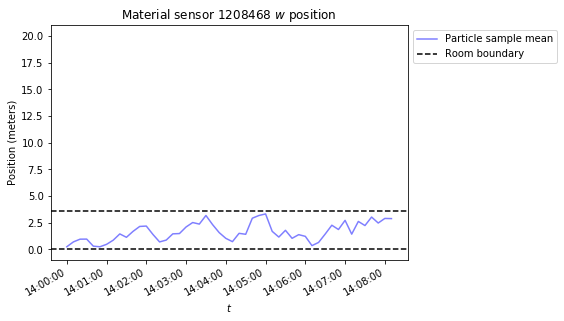

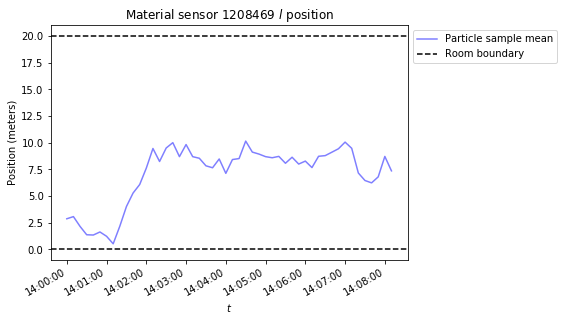

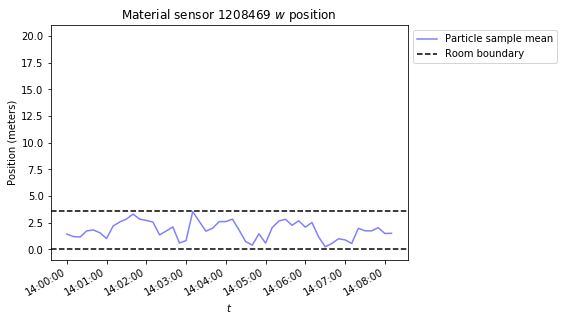

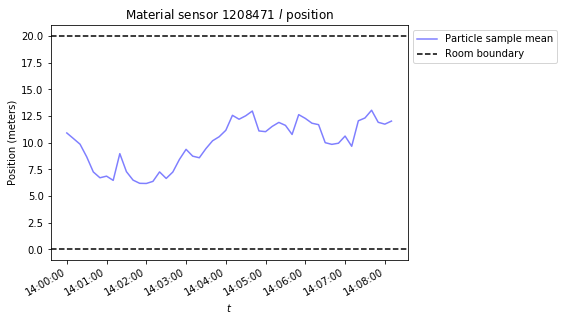

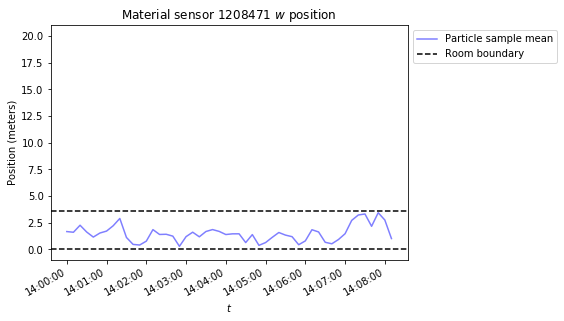

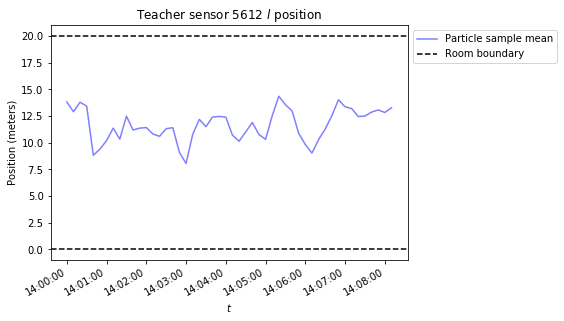

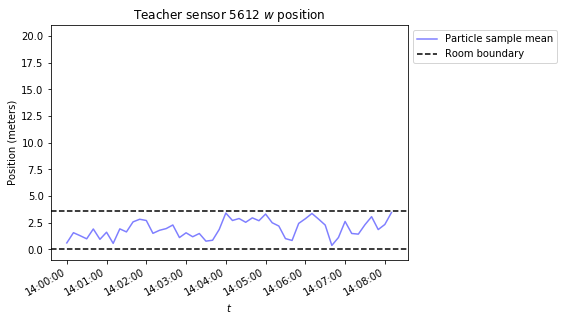

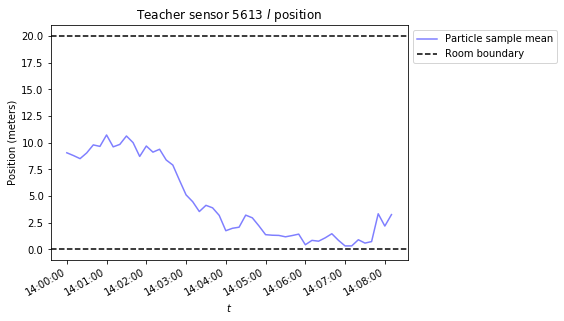

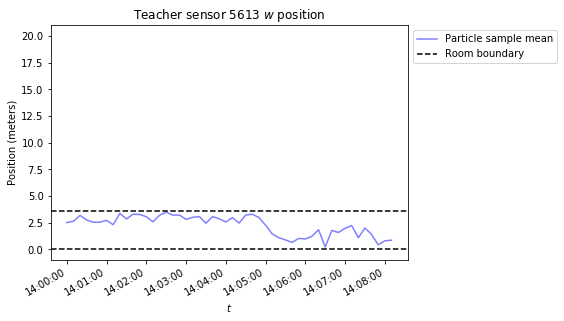

In [54]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(
        t_test[:num_timesteps_test],
        x_continuous_mean_particle[:,x_var_index],
        'b-',
        alpha=0.5,
        label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles (i.e., sample means plus/minus sample standard deviations).

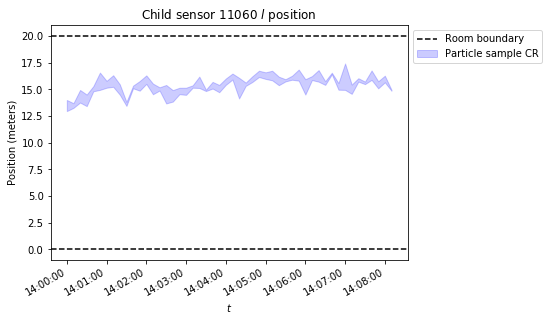

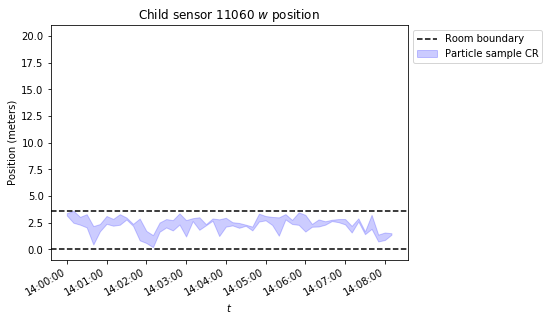

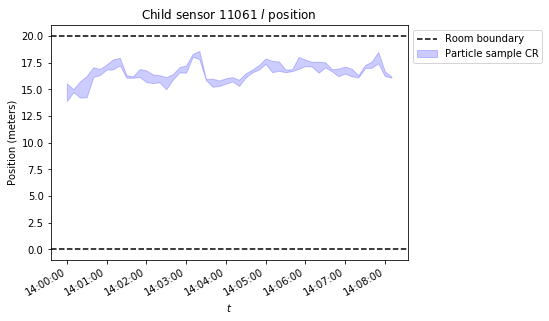

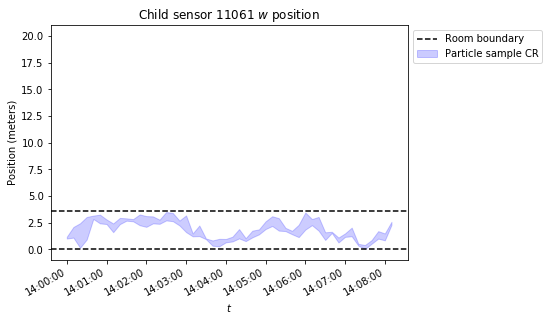

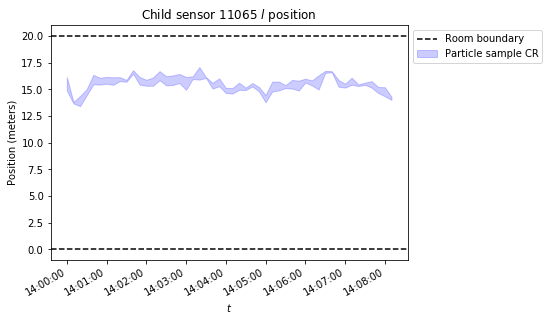

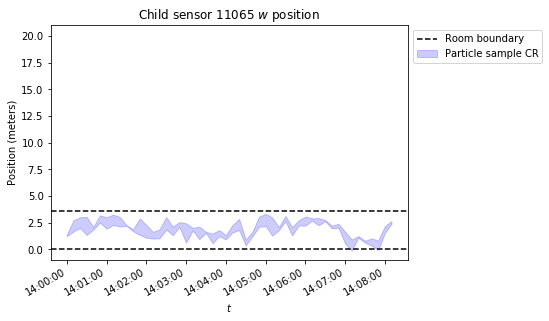

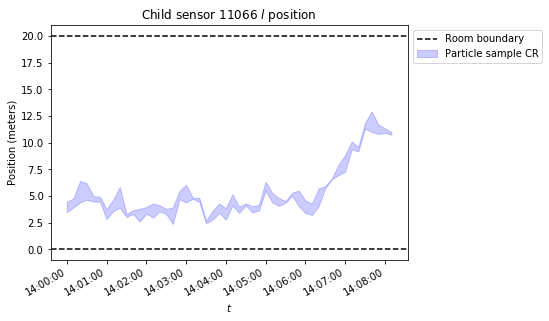

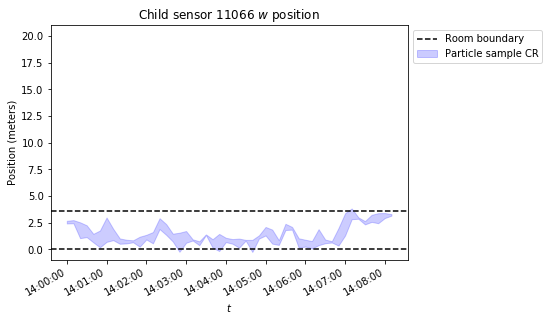

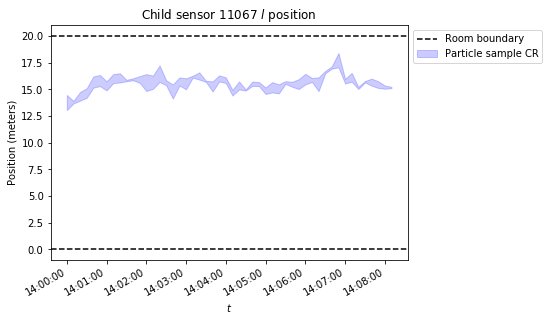

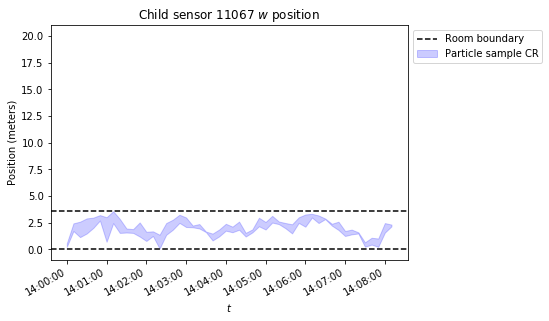

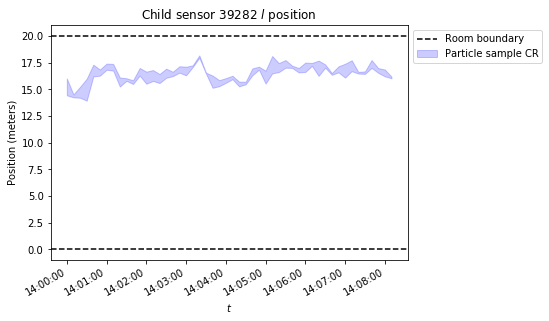

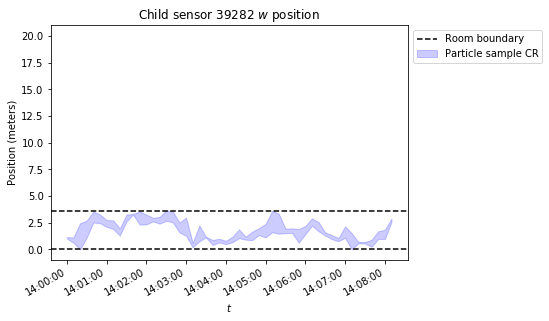

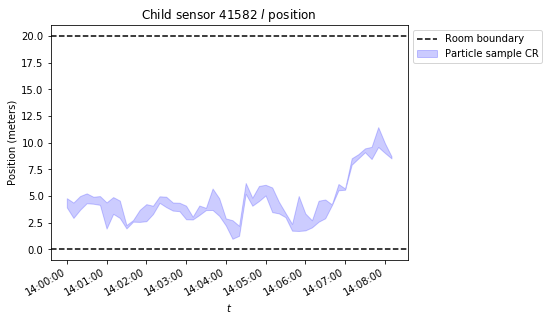

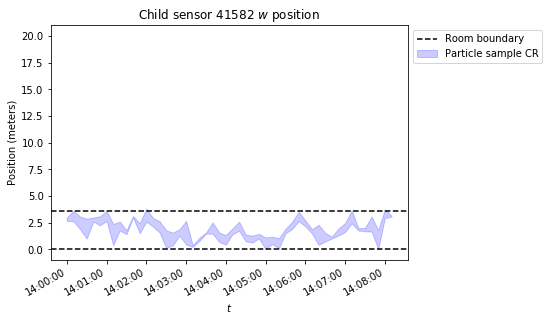

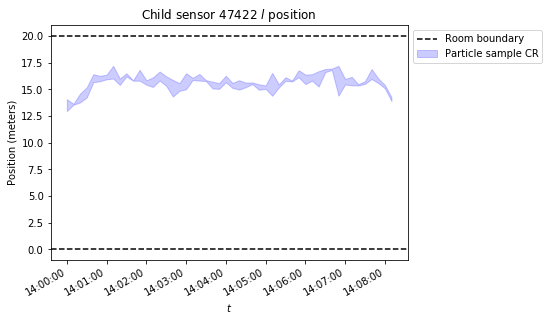

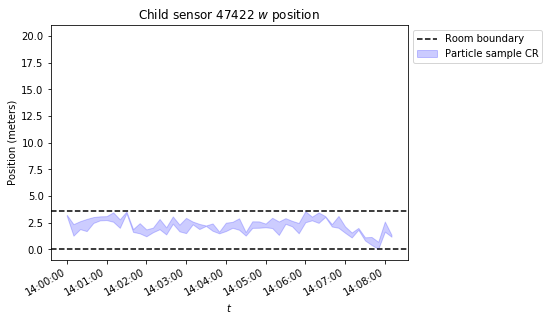

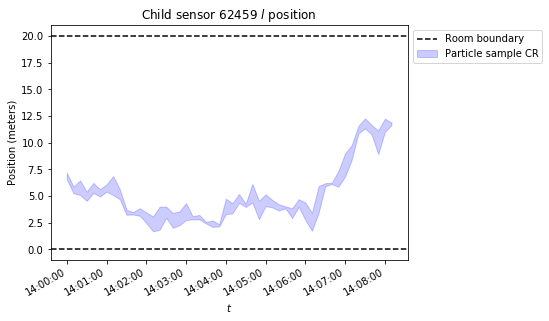

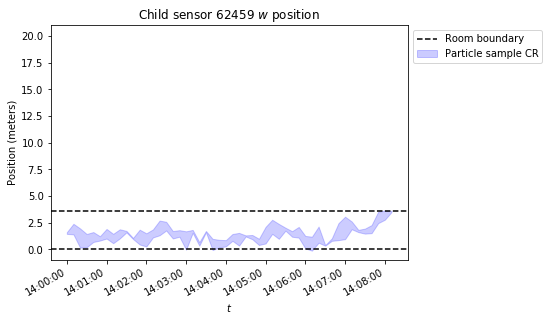

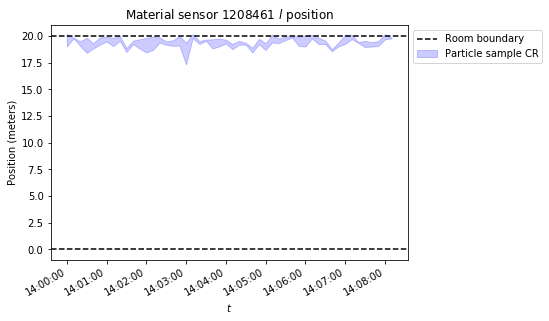

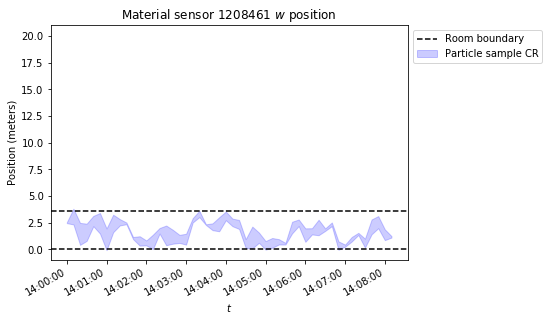

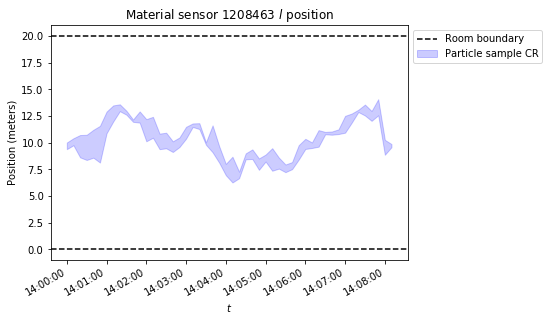

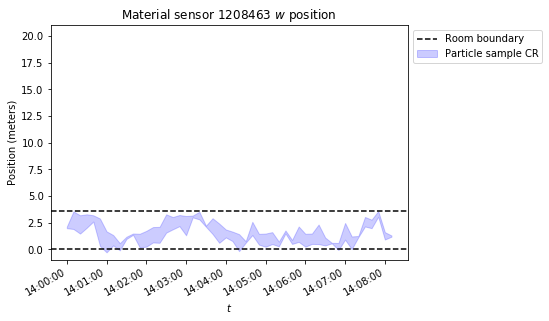

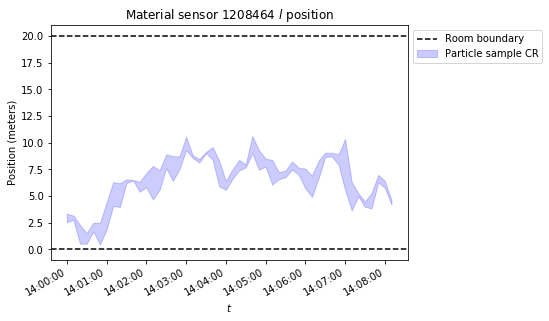

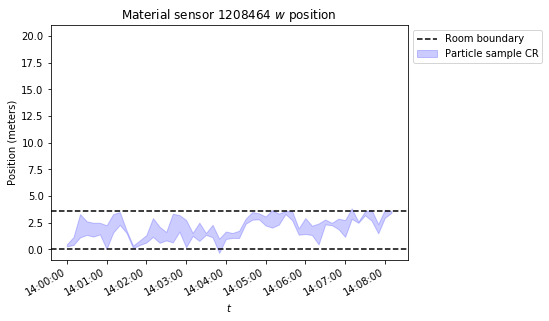

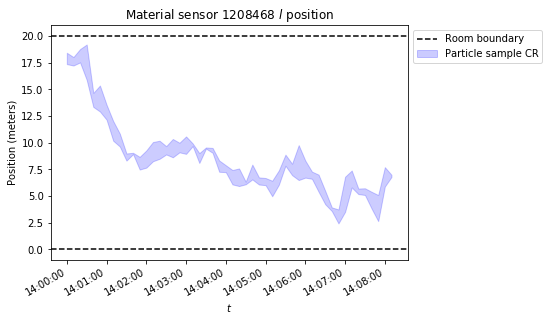

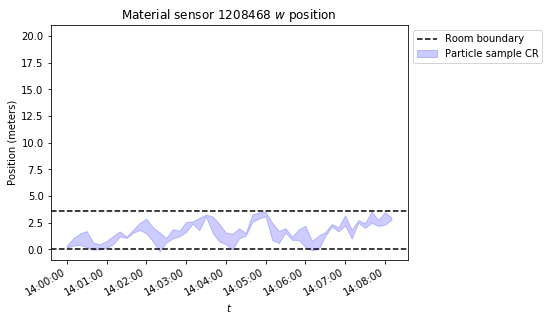

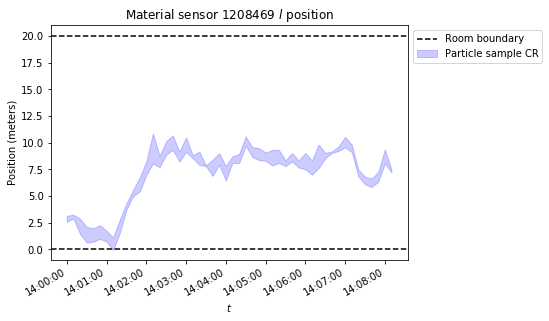

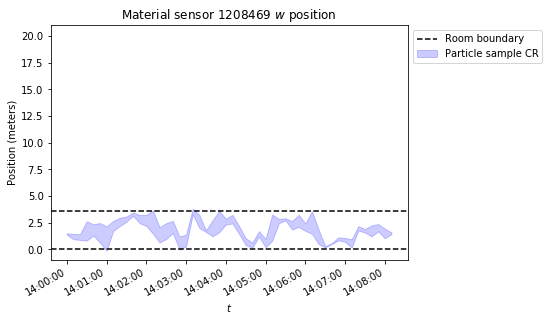

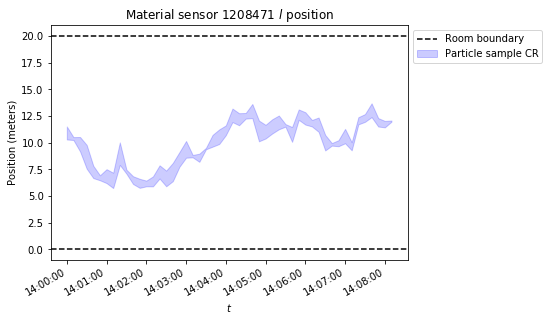

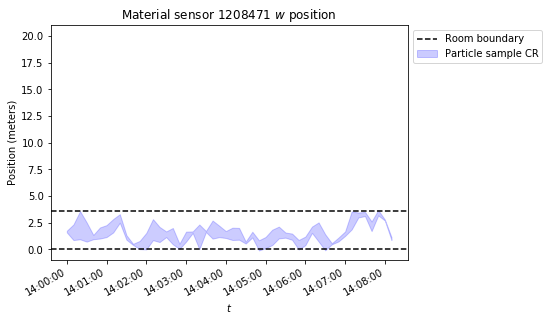

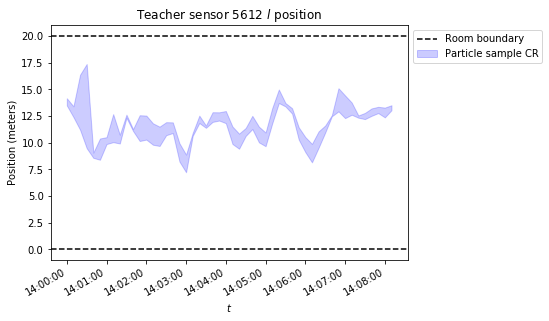

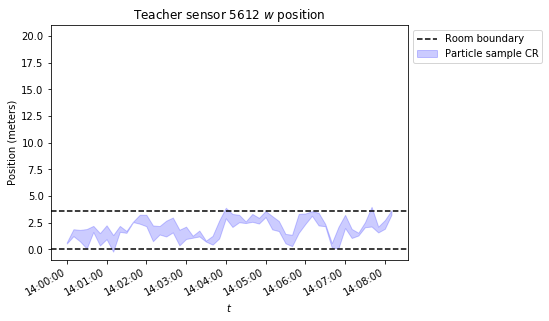

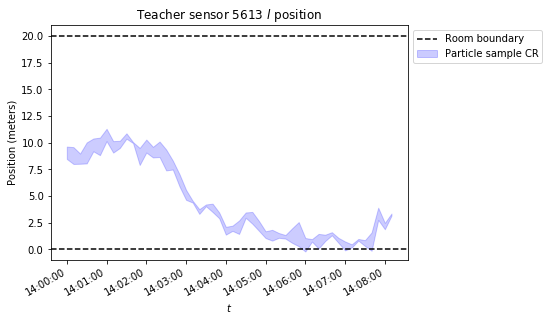

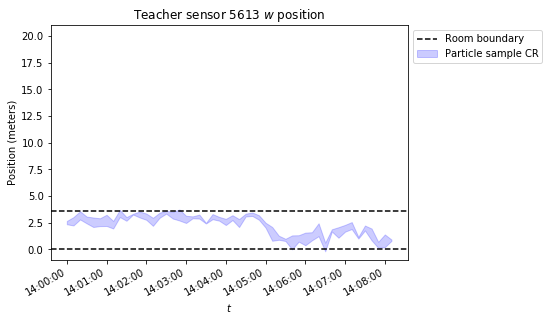

In [55]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.fill_between(
        t_test[:num_timesteps_test],
        x_continuous_mean_particle[:,x_var_index] - x_continuous_sd_particle[:, x_var_index],
        x_continuous_mean_particle[:,x_var_index] + x_continuous_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

### Simulation

Plot the (simulated) actual positions of the sensors to make sure they have the properties we expect.

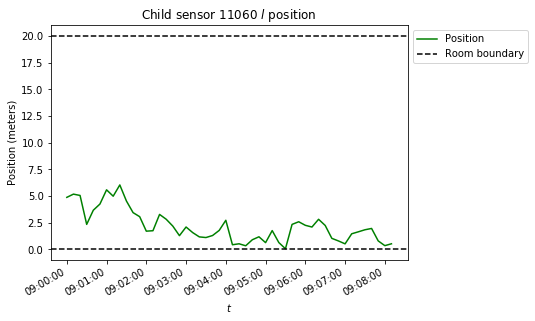

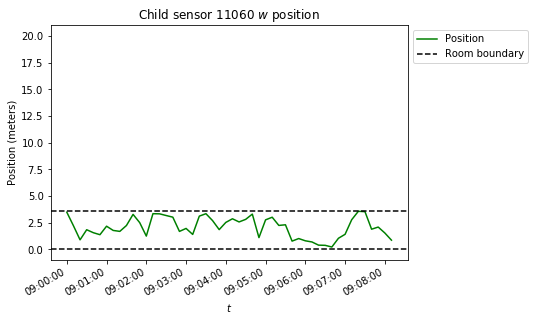

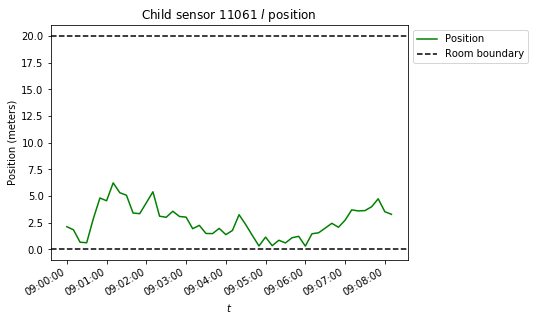

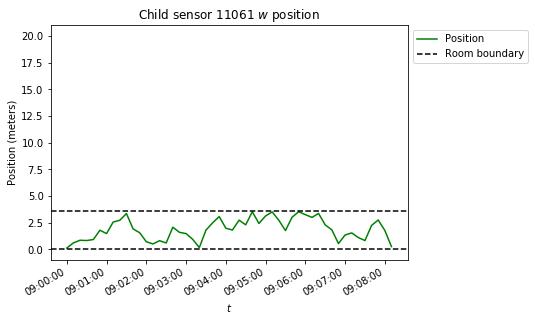

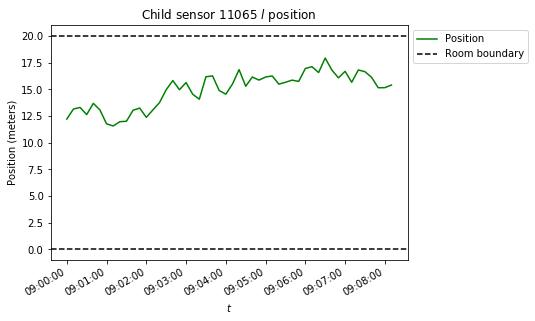

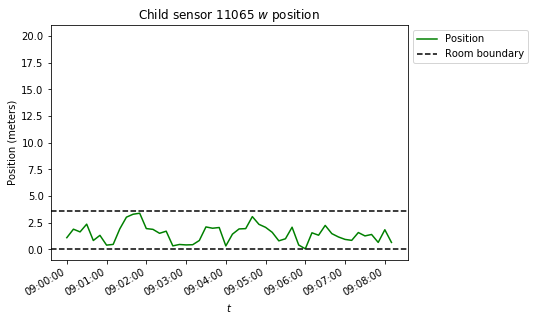

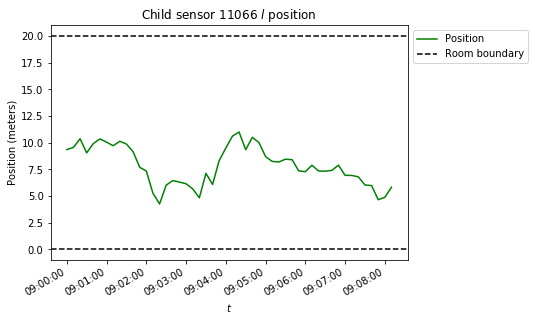

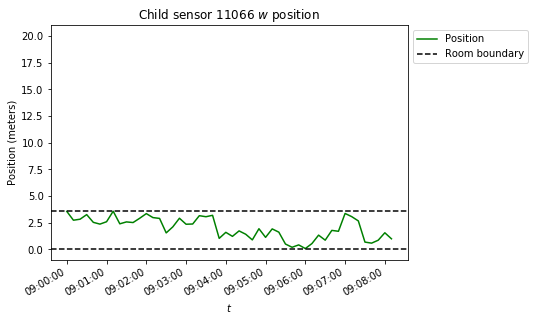

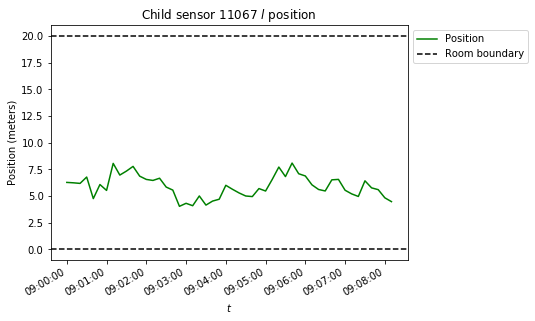

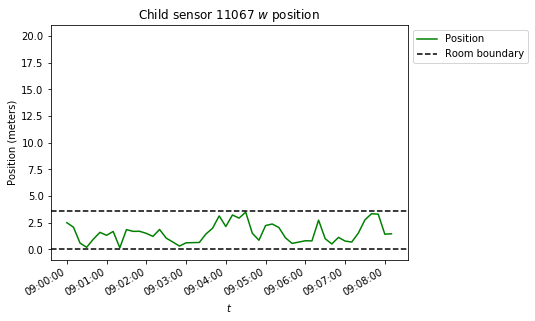

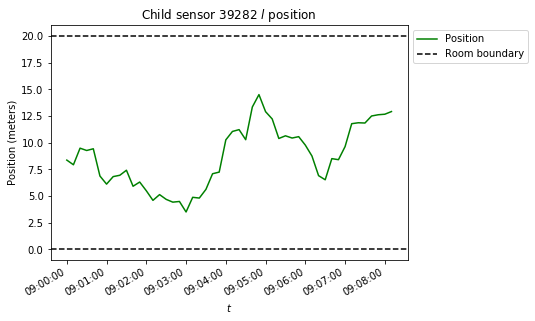

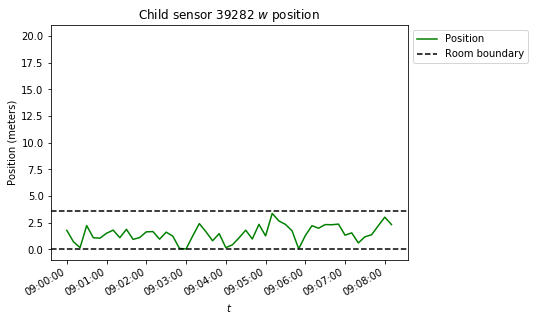

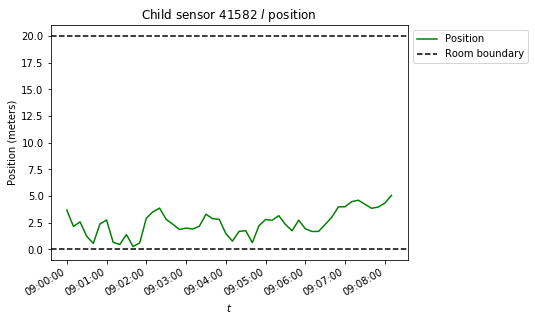

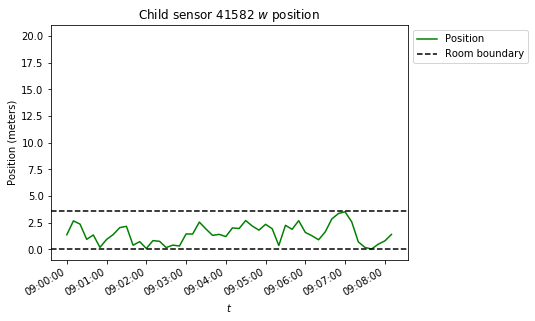

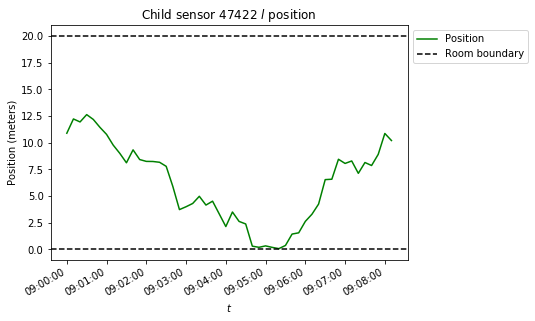

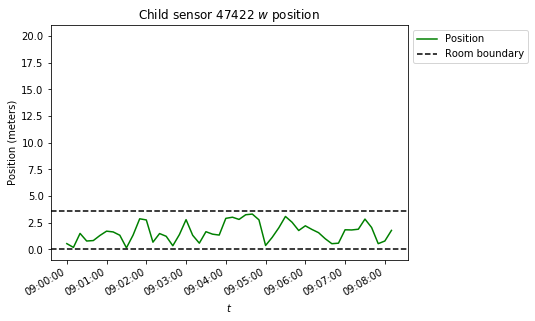

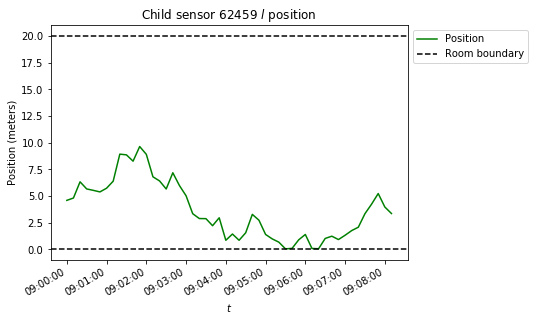

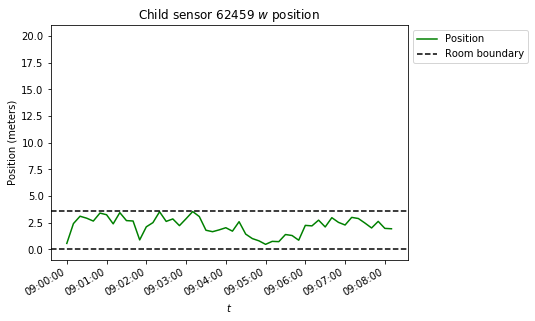

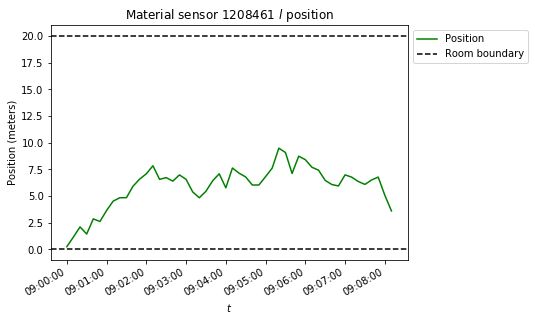

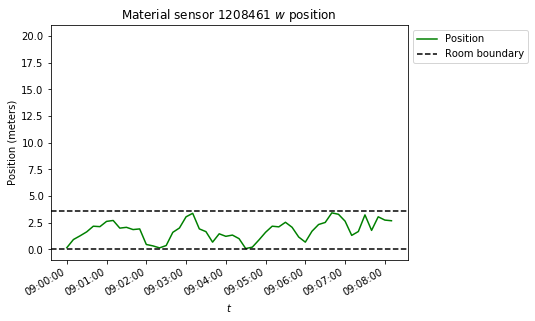

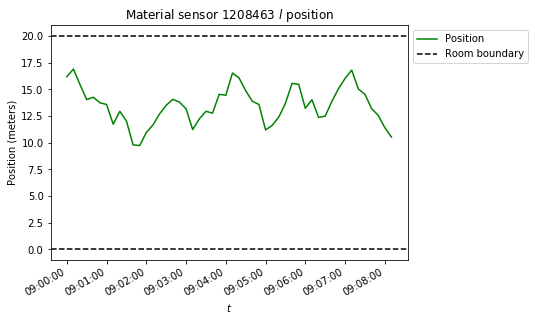

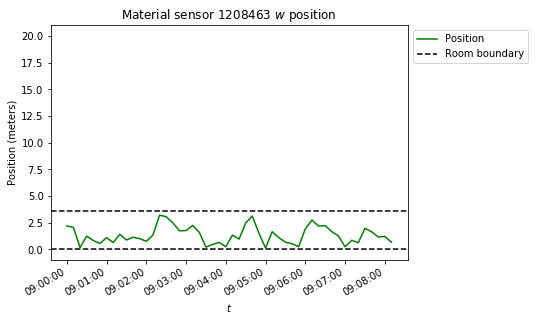

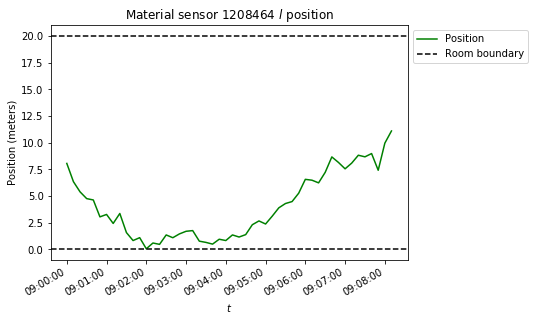

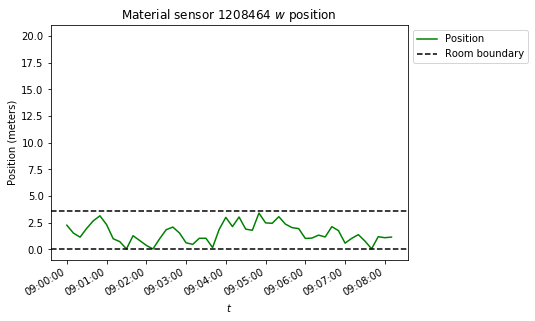

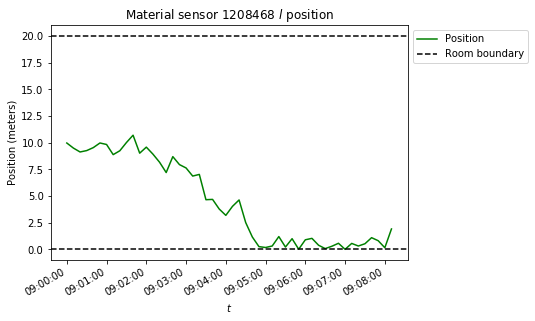

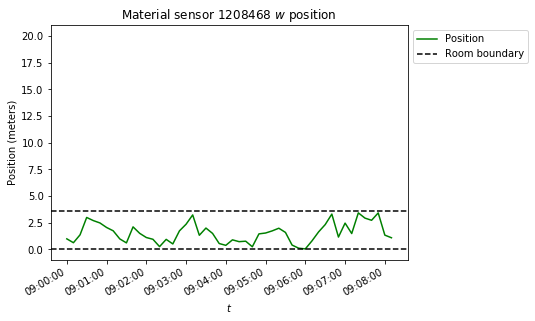

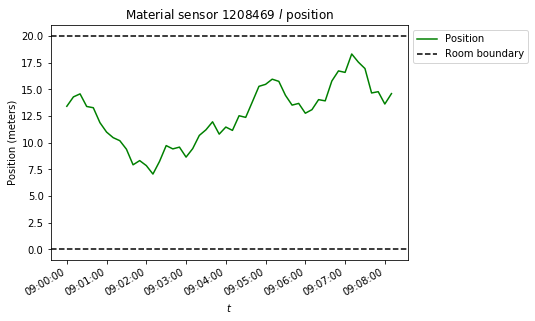

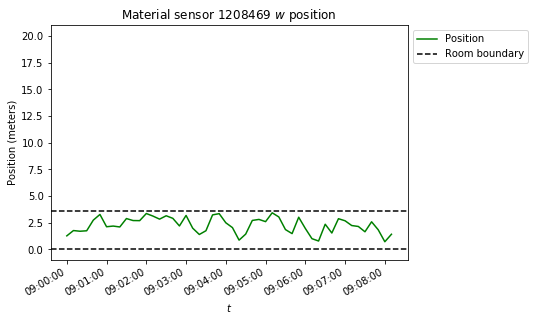

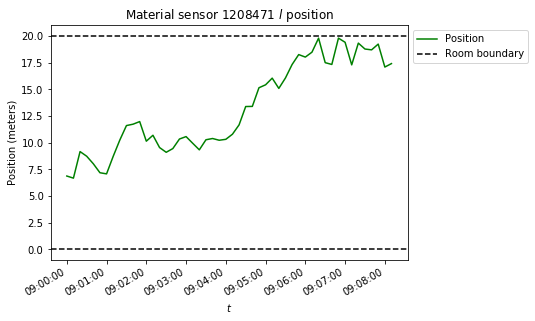

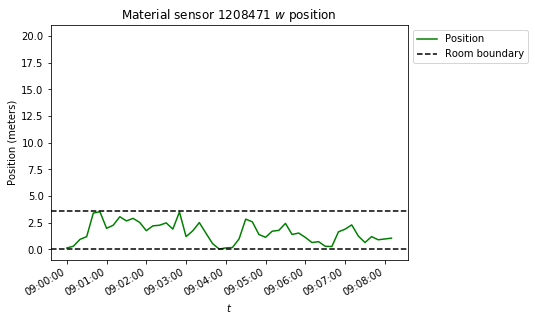

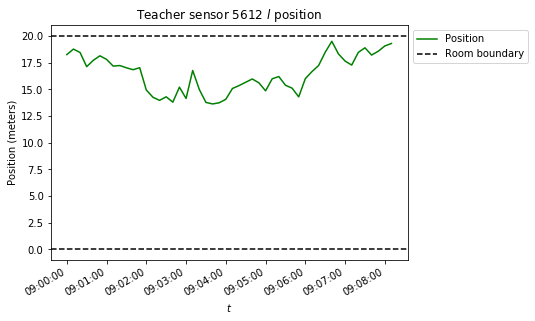

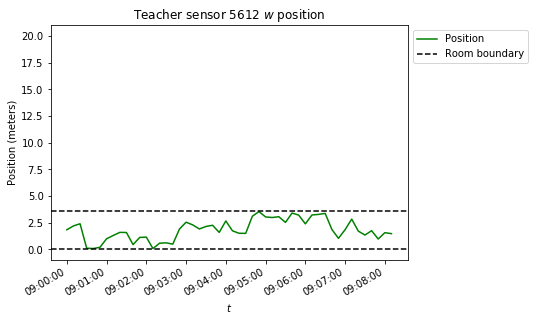

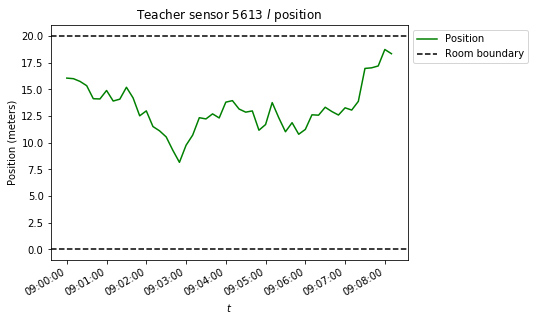

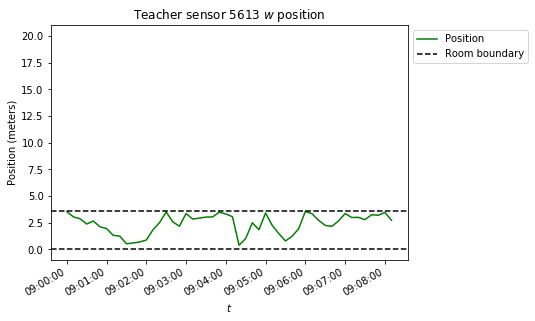

In [56]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:, x_var_index], 'g-', label='Position')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.plot
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

For 10 randomly chosen pairs of sensors, plot the (simulated) measured ping statuses against the (simulated) distances between the sensors. We should see more missed pings for larger distances, but with a lot of noise.

In [57]:
distances_t_sim = sensor_model.distances_test(x_continuous_t_sim)

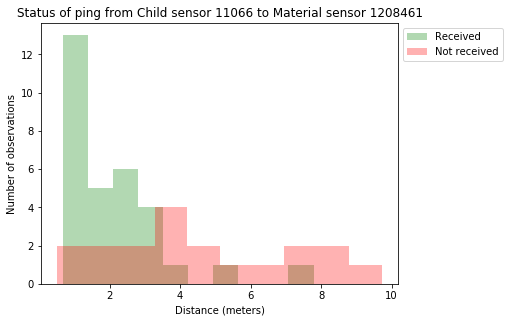

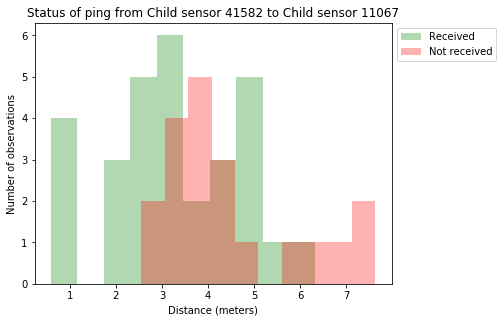

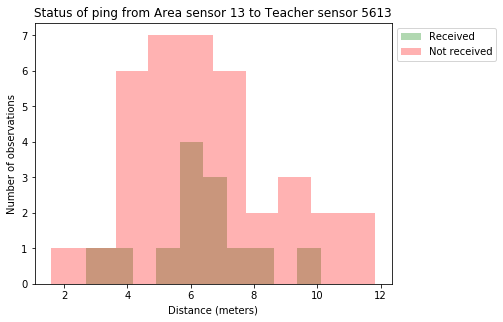

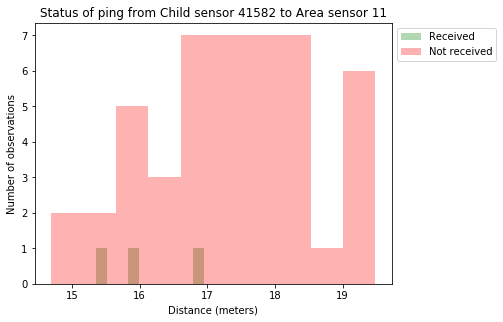

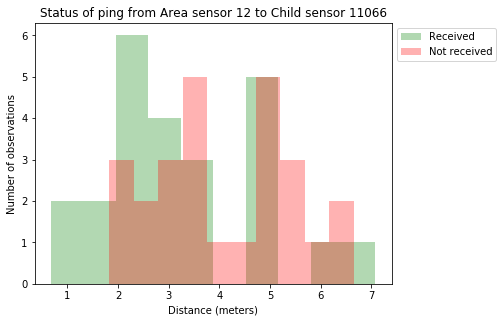

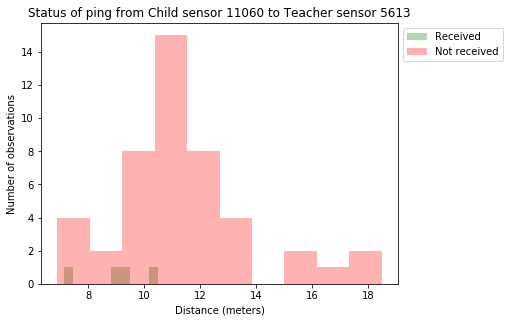

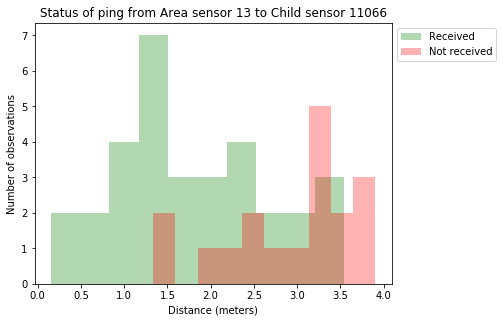

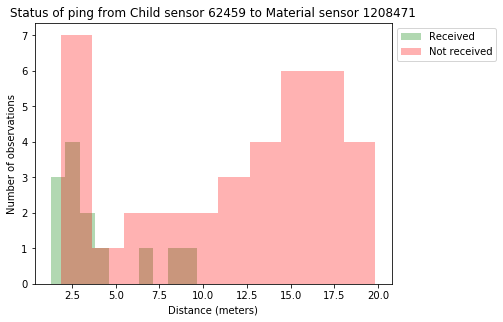

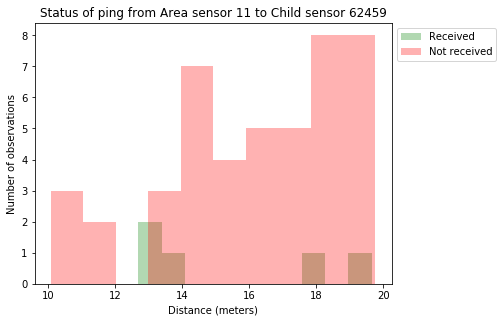

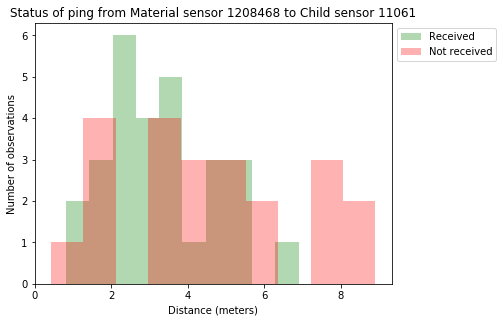

In [58]:
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    plt.hist(
        distances_t_sim[y_discrete_t_sim[:,y_discrete_var_index] == 0, y_discrete_var_index],
        color='green',
        alpha=0.3,
        label=variable_structure.ping_status_names[0])
    plt.hist(
        distances_t_sim[y_discrete_t_sim[:,y_discrete_var_index] == 1, y_discrete_var_index],
        color='red',
        alpha=0.3,
        label=variable_structure.ping_status_names[1])
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Number of observations')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For 10 randomly chosen pairs of sensors, plot the (simulated) measured RSSI of the received pings versus the (simulated) distances between the sensors. We should see a wide range of RSSI readings at each distance, but with a mean value that falls off with distance and a hard cut-off at -96 dB.

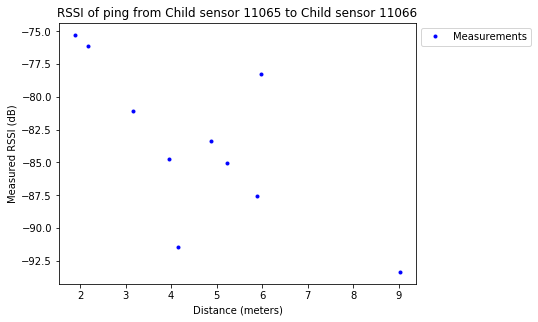

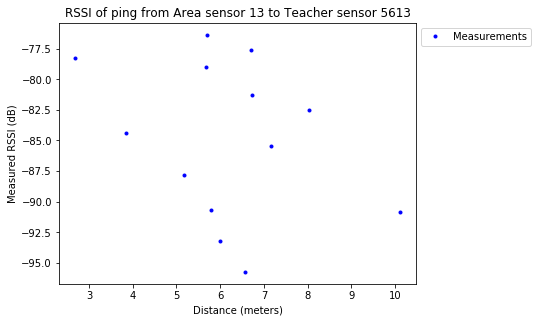

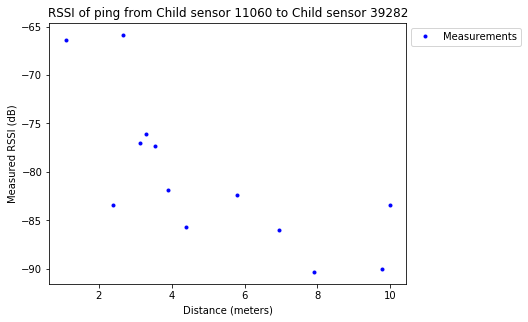

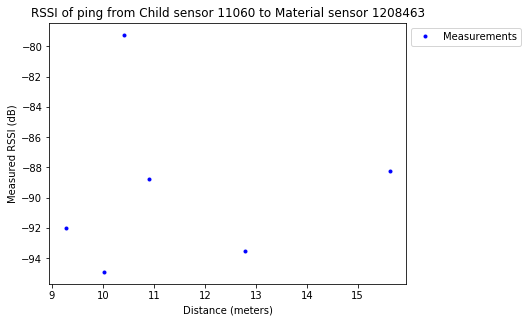

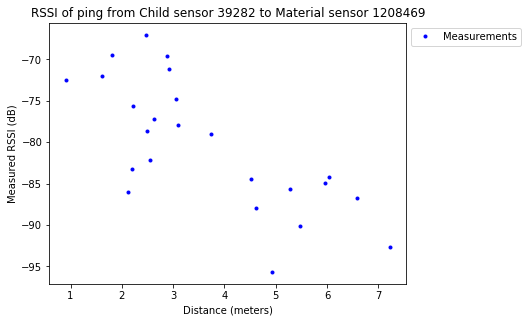

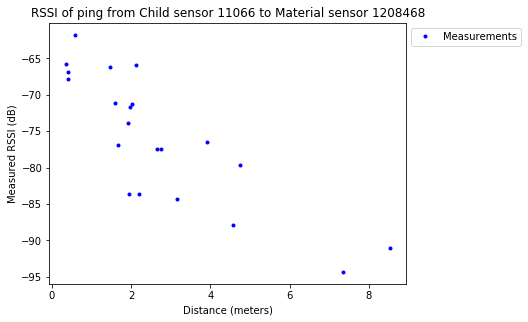

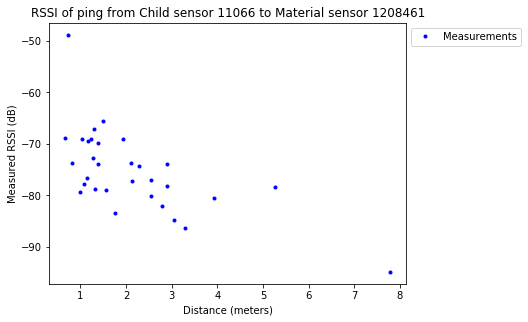

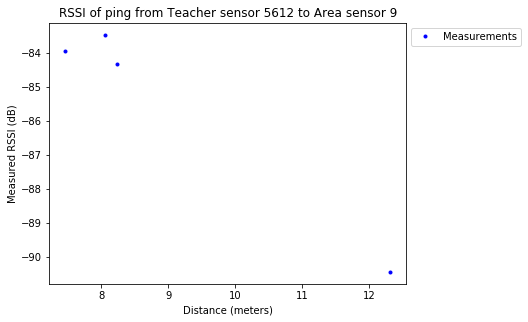

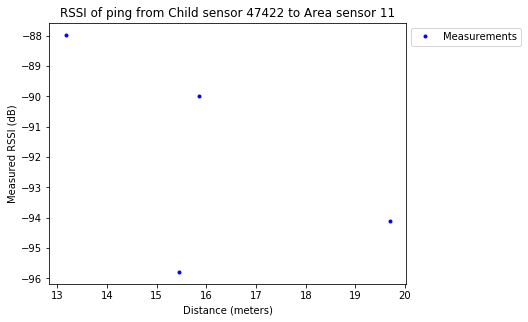

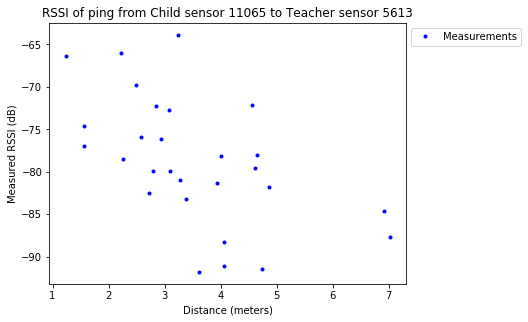

In [59]:
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    plt.plot(
        distances_t_sim[y_discrete_t_sim[:,y_continuous_var_index] == 0, y_continuous_var_index],
        y_continuous_t_sim[y_discrete_t_sim[:,y_continuous_var_index] == 0, y_continuous_var_index],
        'b.',
        label='Measurements')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Measured RSSI (dB)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Plot the maximum particle weight for each time step. Again, when this reaches 1.0, the particle filter has collapsed around a single $\mathbf{X}$ value.

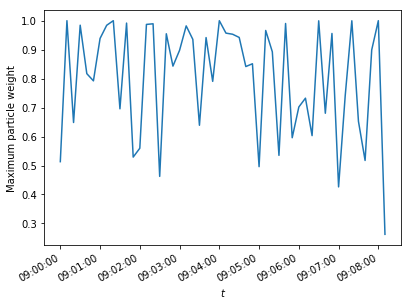

In [60]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim, max_weights_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Maximum particle weight')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the number of sampled ancestor particles at each time step. Again, when this shrinks to 1, the particle filter has collapsed around a single $\mathbf{X}$ value.

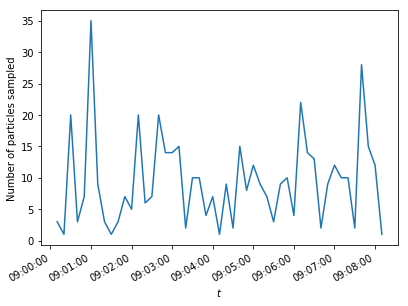

In [61]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim[1:], num_ancestors_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of particles sampled')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample means of the particles against the (simulated) actual values of $\mathbf{X}_t$.

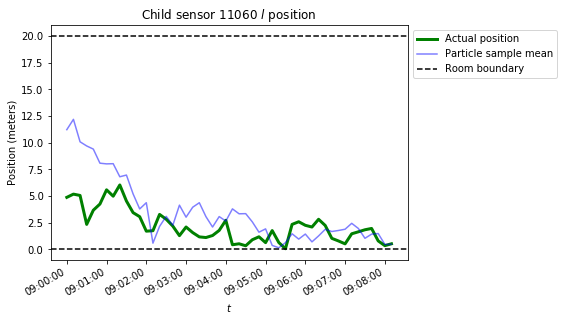

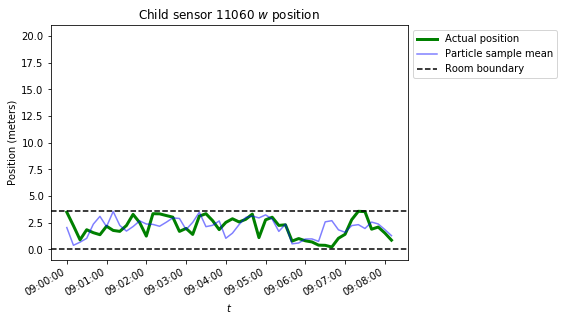

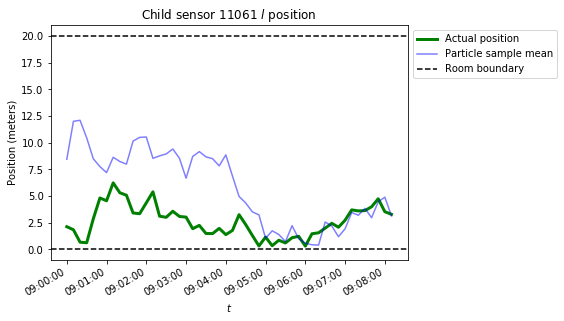

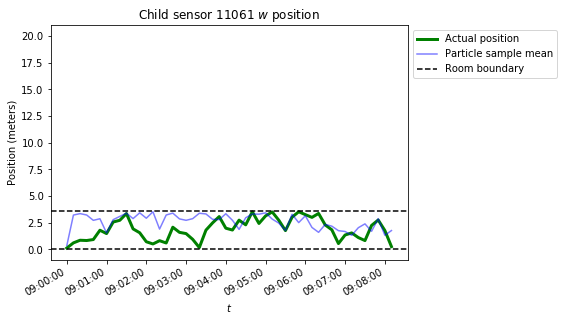

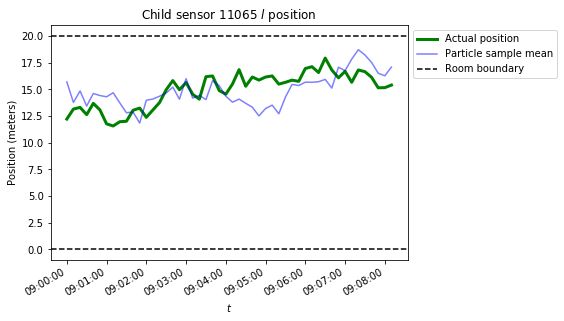

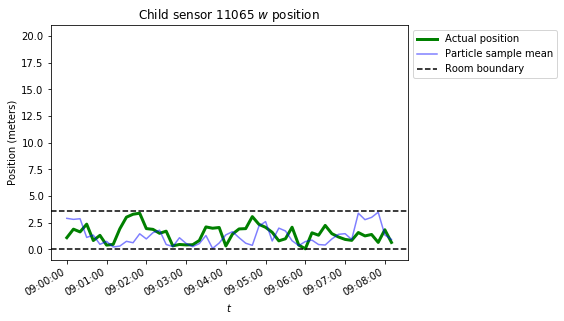

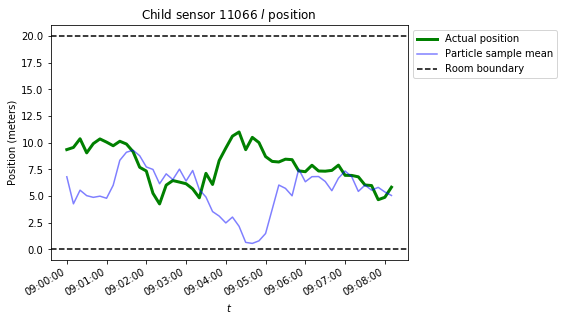

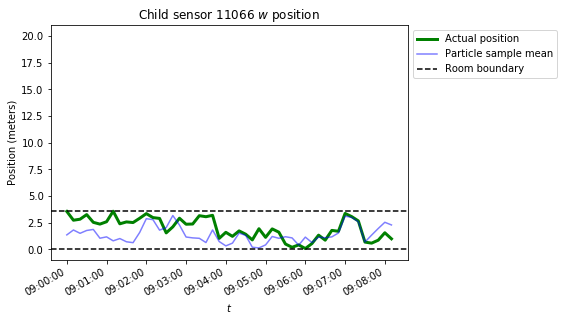

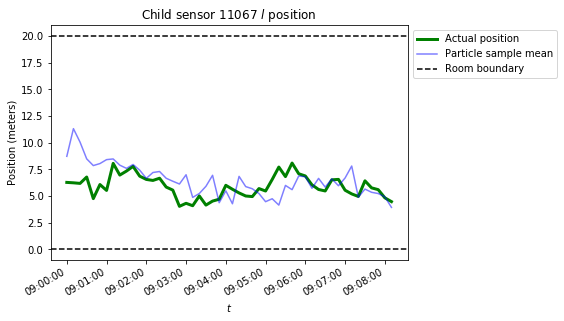

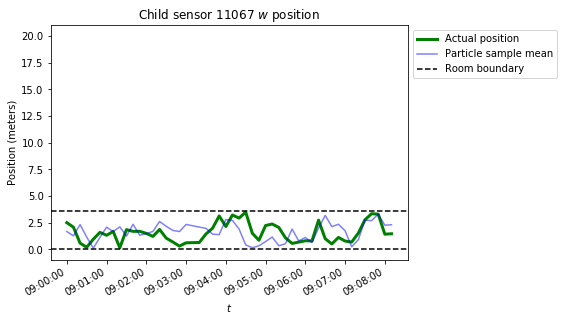

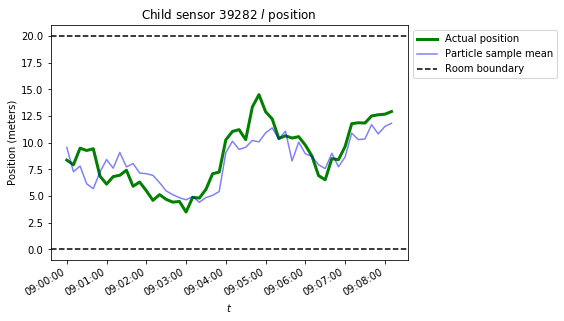

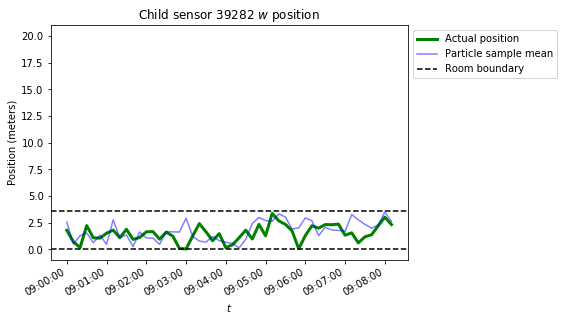

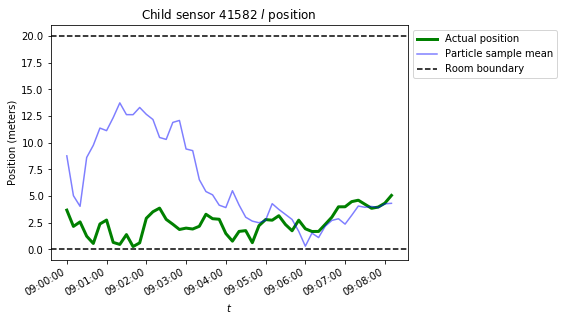

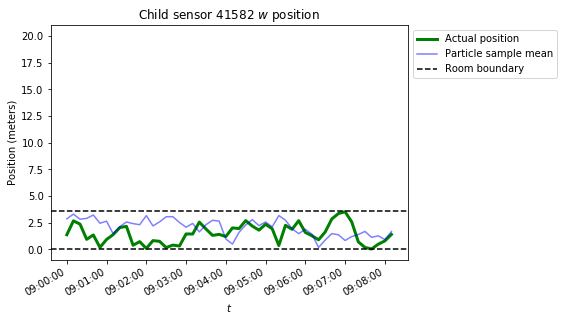

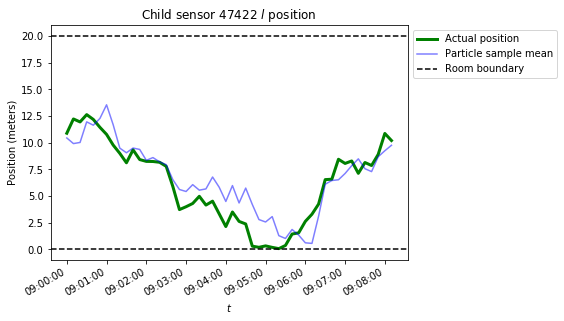

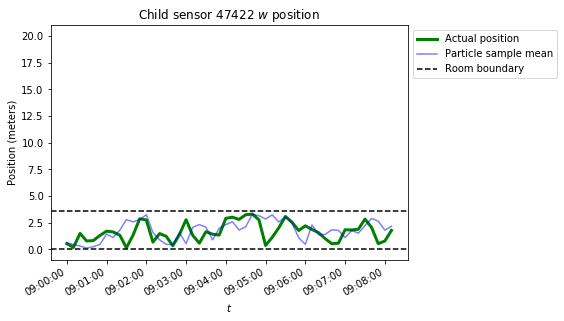

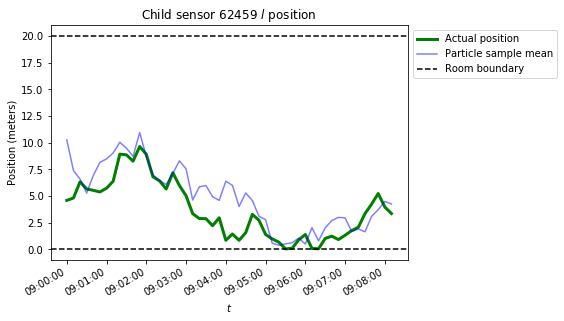

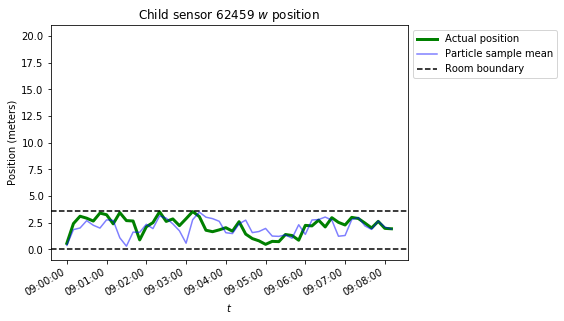

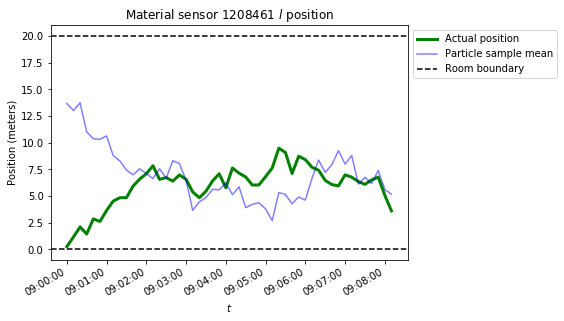

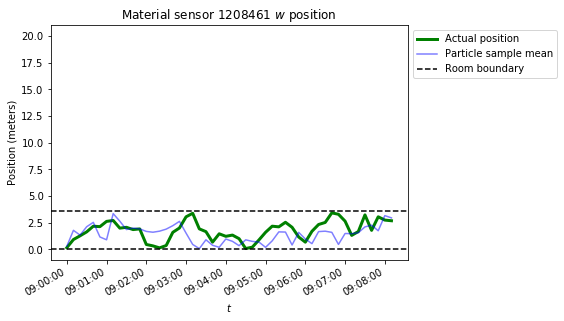

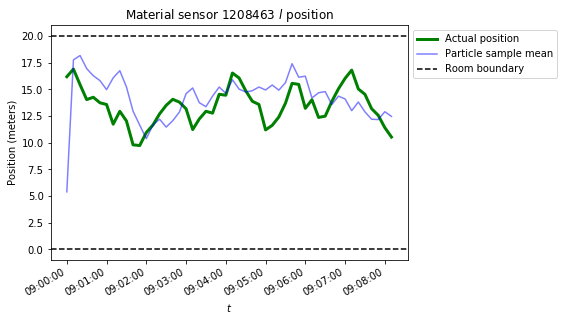

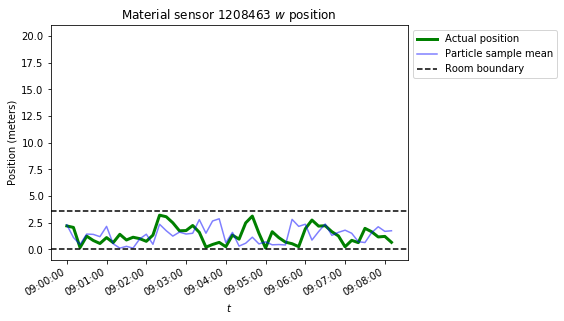

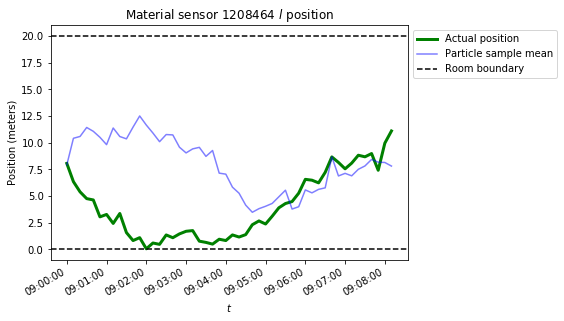

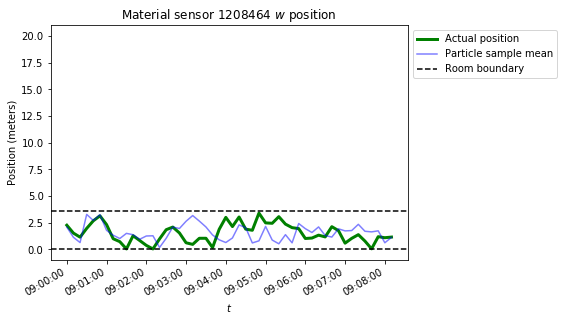

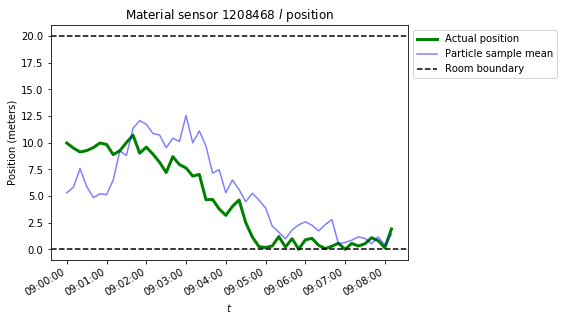

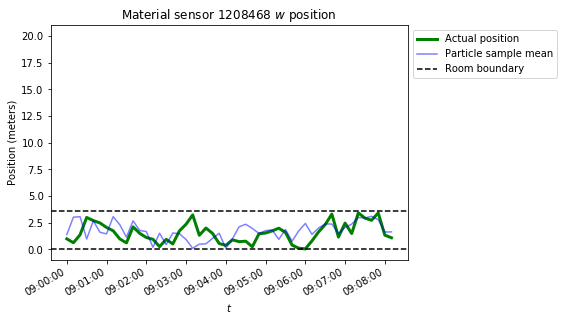

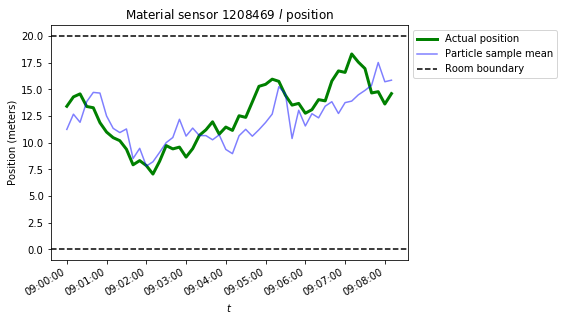

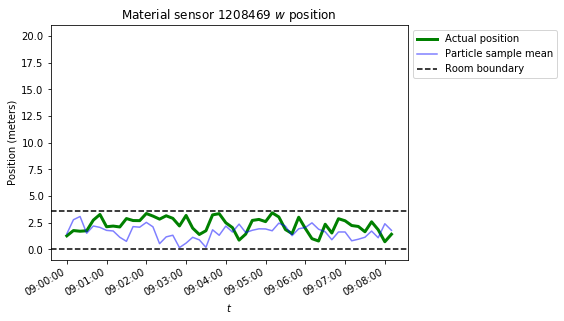

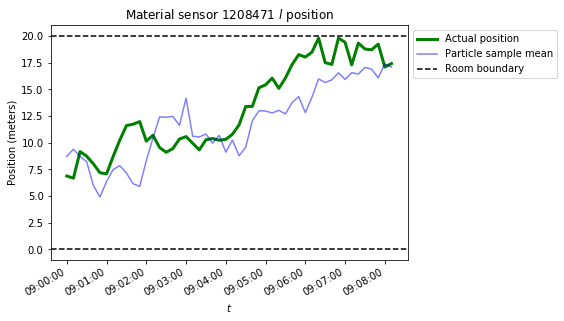

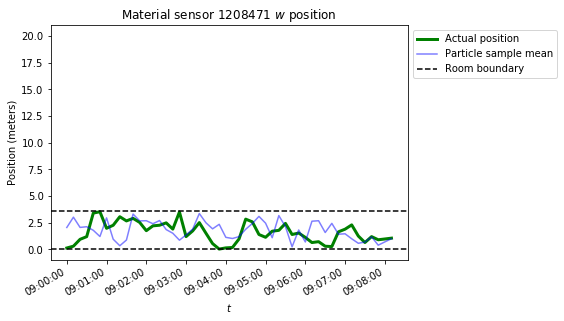

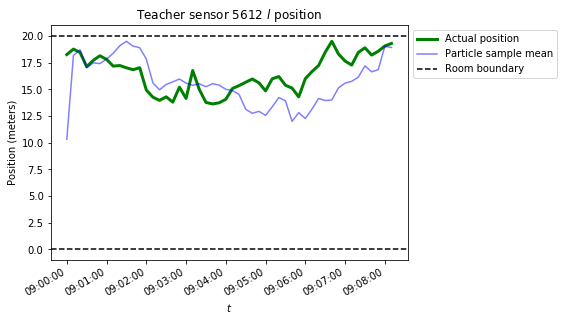

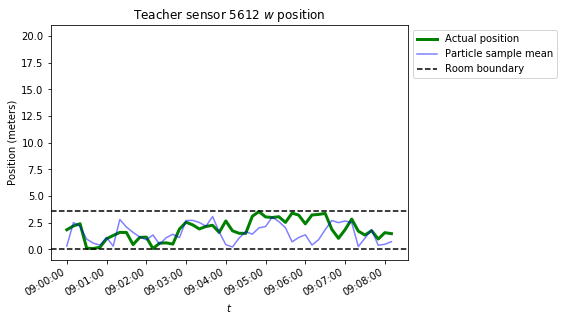

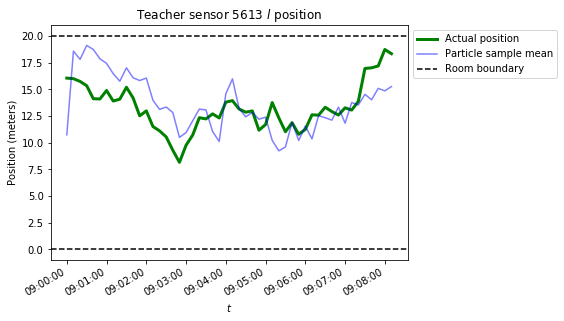

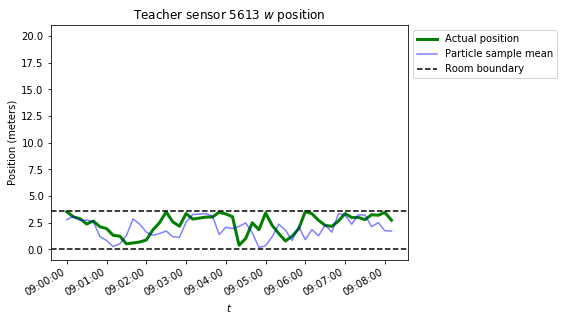

In [62]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.plot(t_sim, x_continuous_mean_particle_sim[:,x_var_index], 'b-', alpha=0.5, label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles (i.e., sample means plus/minus sample standard deviations) against the (simulated) actual values of $\mathbf{X}_t$.

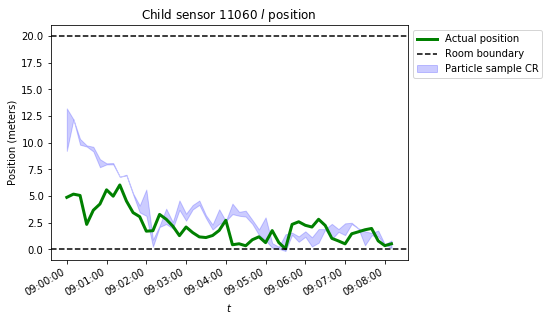

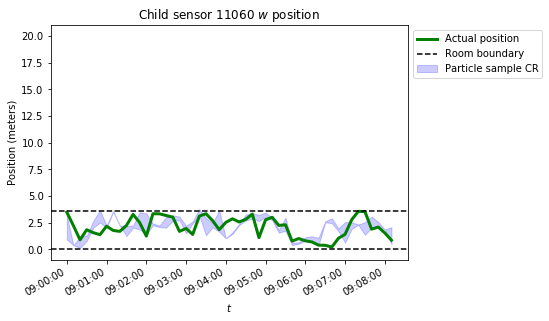

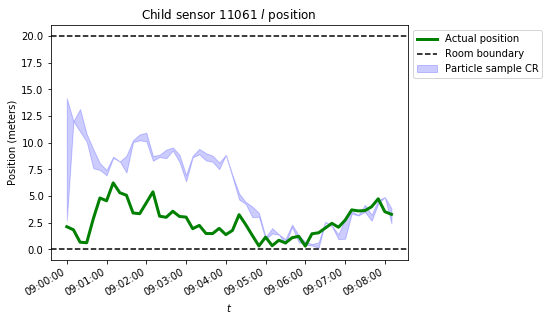

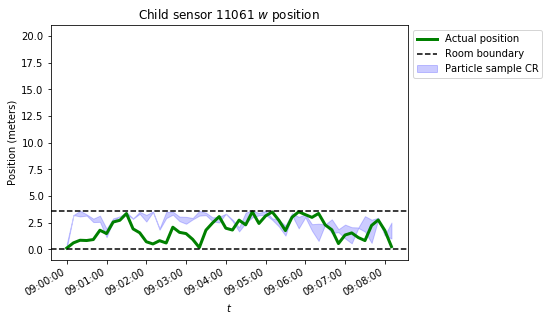

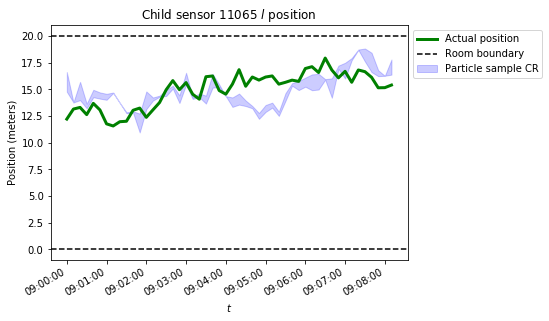

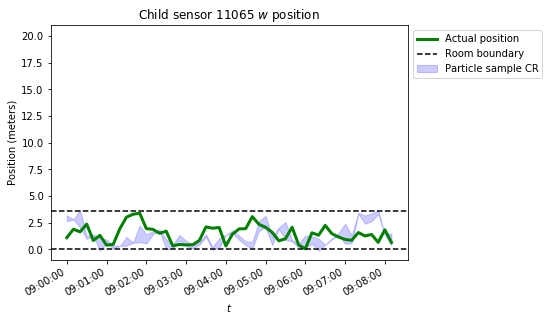

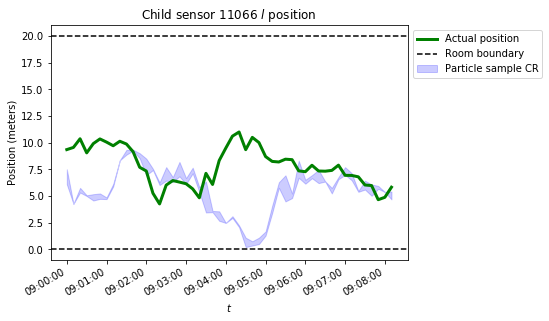

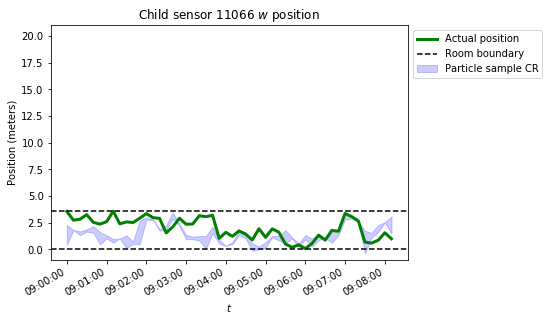

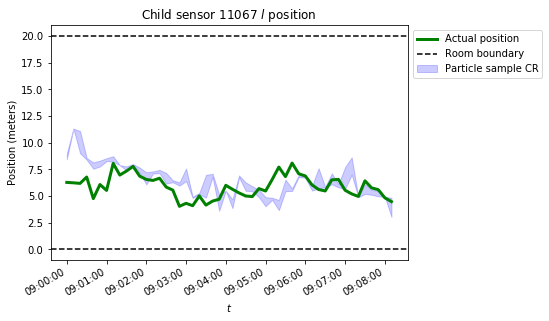

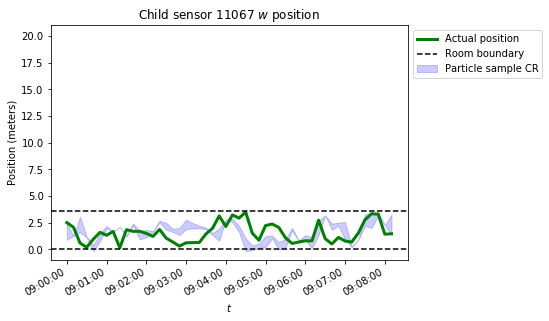

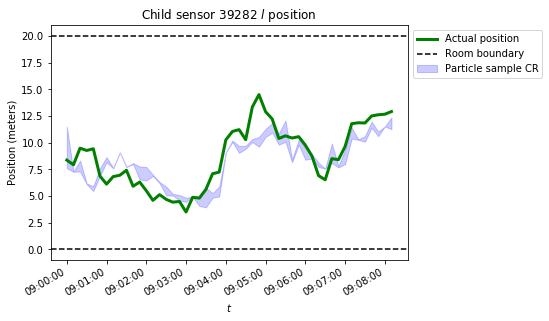

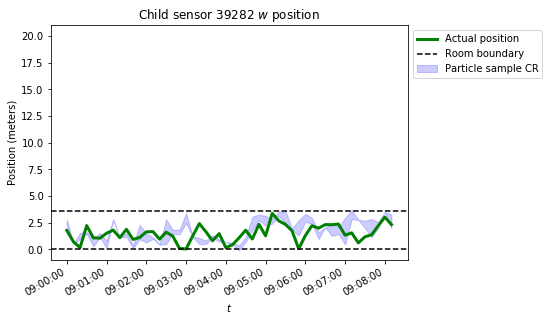

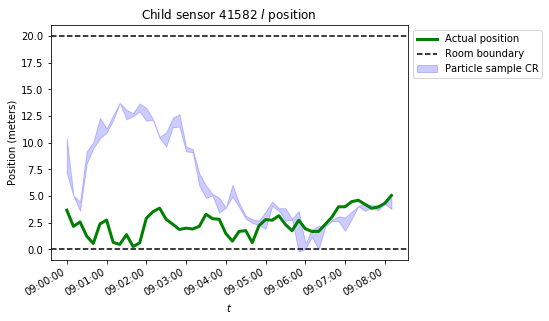

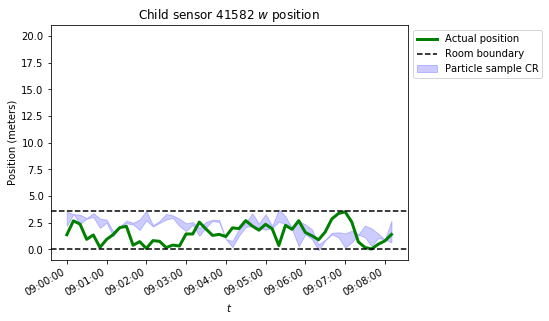

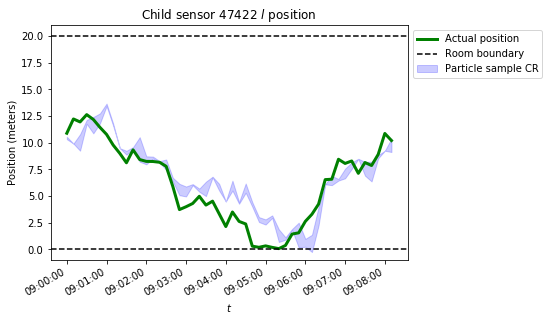

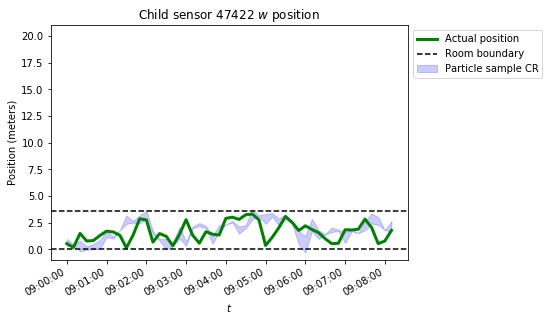

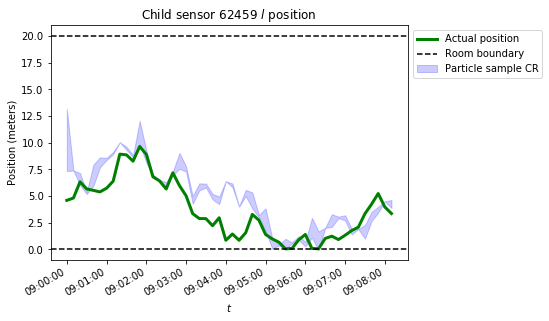

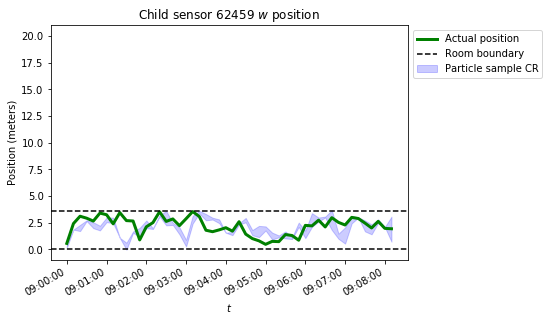

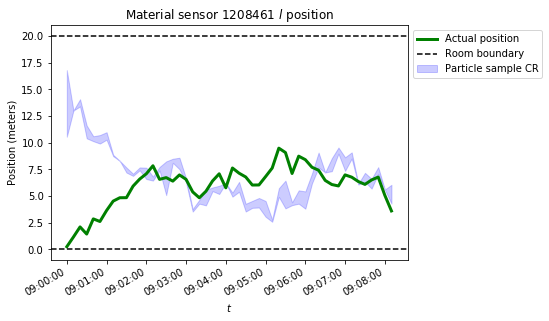

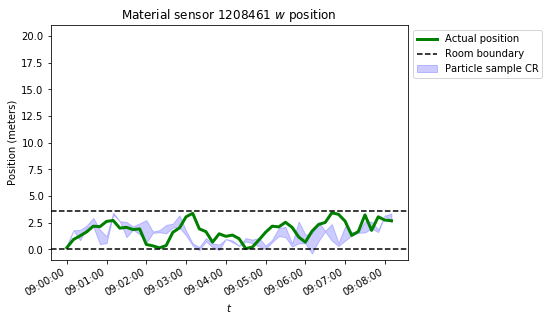

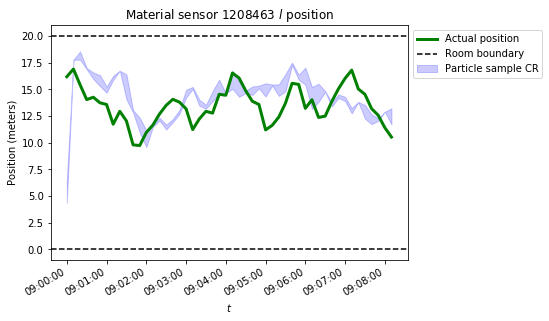

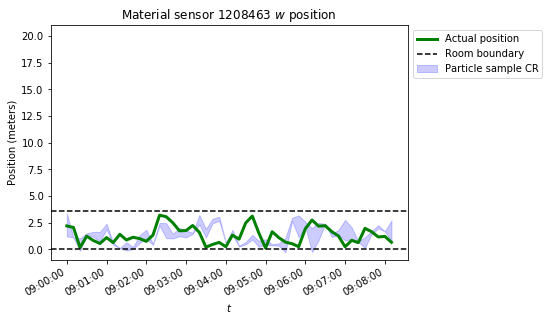

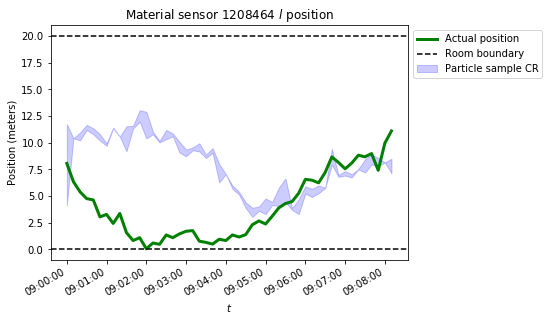

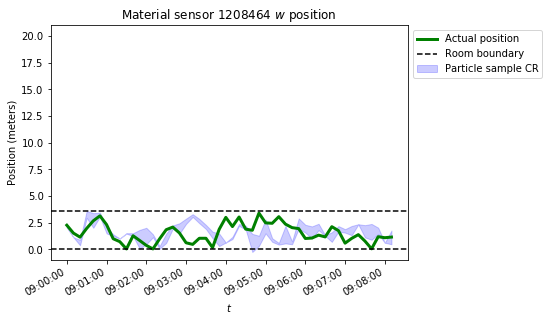

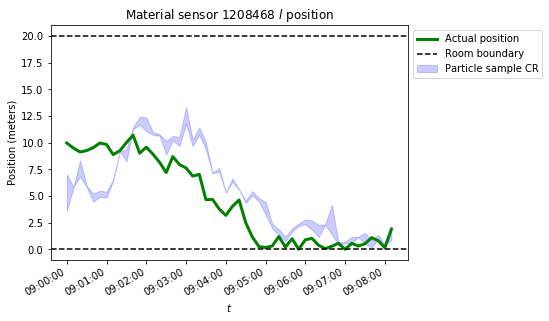

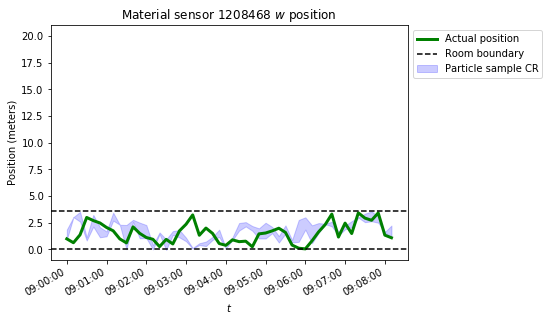

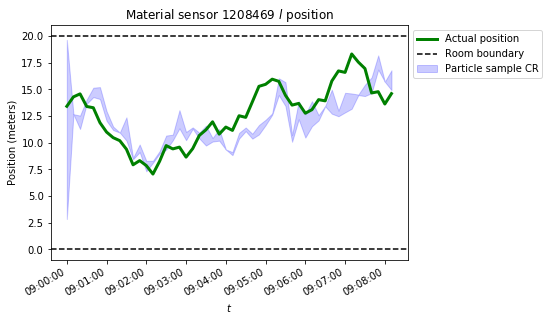

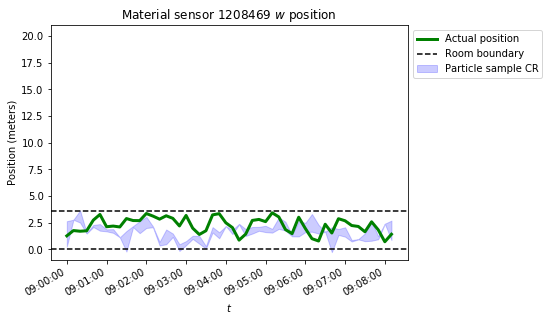

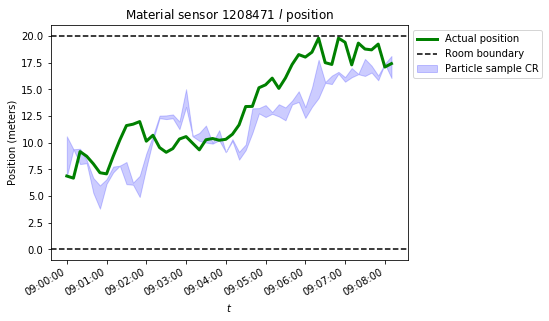

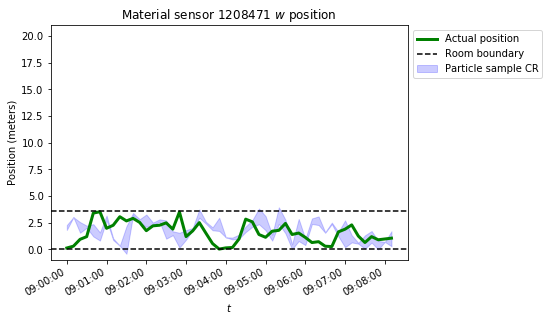

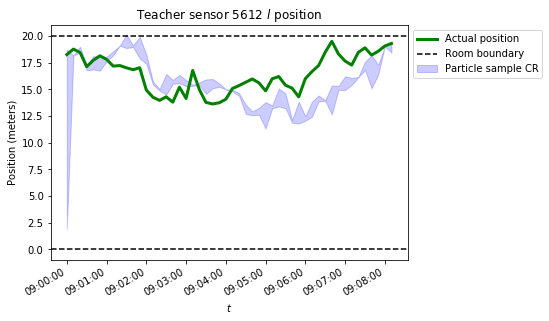

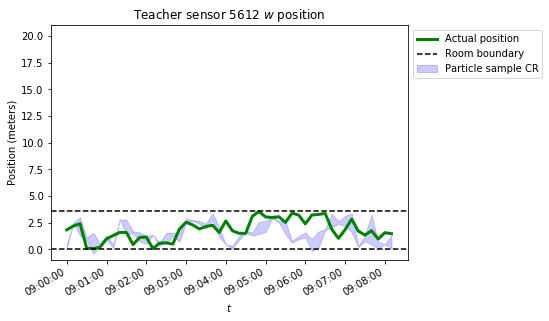

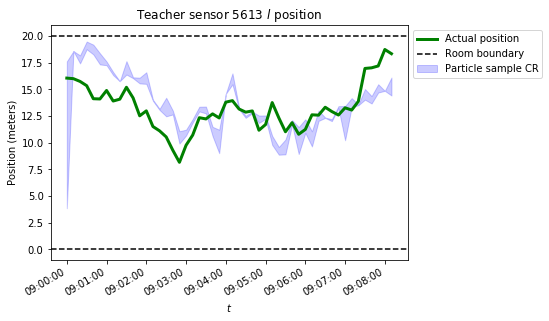

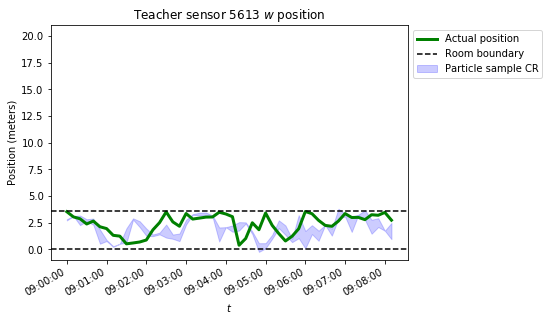

In [63]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.fill_between(
        t_sim,
        x_continuous_mean_particle_sim[:,x_var_index] - x_continuous_sd_particle_sim[:, x_var_index],
        x_continuous_mean_particle_sim[:,x_var_index] + x_continuous_sd_particle_sim[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

In [64]:
x_discrete_first_test, x_continuous_first_test = sensor_model.x_initial_sample_test(
    num_particles) 

In [65]:
x_discrete_first_test.shape

(10000, 0)

In [66]:
x_continuous_first_test.shape

(10000, 34)

In [67]:
x_discrete_second_test, x_continuous_second_test = sensor_model.x_bar_x_previous_sample_test(
    x_discrete_first_test,
    x_continuous_first_test,
    np.timedelta64(10, 's'))

In [68]:
x_discrete_second_test.shape

(10000, 0)

In [69]:
x_continuous_second_test.shape

(10000, 34)

In [70]:
x_discrete_third_test, x_continuous_third_test = sensor_model.x_bar_x_previous_sample_test(
    x_discrete_second_test,
    x_continuous_second_test,
    np.timedelta64(10, 's'))

In [71]:
x_discrete_third_test.shape

(10000, 0)

In [72]:
x_continuous_third_test.shape

(10000, 34)

In [73]:
y_discrete_first_test, y_continuous_first_test = sensor_model.y_bar_x_sample_test(
    x_discrete_first_test,
    x_continuous_first_test)

In [74]:
y_discrete_first_test.shape

(10000, 350)

In [75]:
y_continuous_first_test.shape

(10000, 350)

In [76]:
log_pdf_test = sensor_model.y_bar_x_log_pdf_test(
    x_discrete_first_test,
    x_continuous_first_test,
    y_discrete_first_test,
    y_continuous_first_test)

In [77]:
log_pdf_test.shape

(10000,)

In [78]:
distances_test = sensor_model.distances_test(x_continuous_first_test)

In [79]:
distances_test.shape

(10000, 350)

In [80]:
ping_success_probabilities_test = sensor_model.ping_success_probabilities_test(distances_test)

In [81]:
ping_success_probabilities_test.shape

(10000, 350)

In [82]:
rssi_untruncated_mean_test = sensor_model.rssi_untruncated_mean_test(distances_test)

In [83]:
rssi_untruncated_mean_test.shape

(10000, 350)

In [84]:
x_discrete_first_single_test, x_continuous_first_single_test = sensor_model.x_initial_sample_test(
    1) 

In [85]:
x_discrete_first_single_test.shape

(0,)

In [86]:
x_continuous_first_single_test.shape

(34,)

In [87]:
x_discrete_second_single_test, x_continuous_second_single_test = sensor_model.x_bar_x_previous_sample_test(
    x_discrete_first_single_test,
    x_continuous_first_single_test,
    np.timedelta64(10, 's'))

In [88]:
x_discrete_second_single_test.shape

(0,)

In [89]:
x_continuous_second_single_test.shape

(34,)

In [90]:
x_discrete_third_single_test, x_continuous_third_single_test = sensor_model.x_bar_x_previous_sample_test(
    x_discrete_second_single_test,
    x_continuous_second_single_test,
    np.timedelta64(10, 's'))

In [91]:
x_discrete_third_single_test.shape

(0,)

In [92]:
x_continuous_third_single_test.shape

(34,)

In [93]:
y_discrete_first_single_test, y_continuous_first_single_test = sensor_model.y_bar_x_sample_test(
    x_discrete_first_single_test,
    x_continuous_first_single_test)

In [94]:
y_discrete_first_single_test.shape

(350,)

In [95]:
y_continuous_first_single_test.shape

(350,)

In [96]:
log_pdf_single_test = sensor_model.y_bar_x_log_pdf_test(
    x_discrete_first_single_test,
    x_continuous_first_single_test,
    y_discrete_first_single_test,
    y_continuous_first_single_test)

In [97]:
log_pdf_single_test.shape

()

In [98]:
distances_single_test = sensor_model.distances_test(x_continuous_first_single_test)

In [99]:
distances_single_test.shape

(350,)

In [100]:
ping_success_probabilities_single_test = sensor_model.ping_success_probabilities_test(distances_single_test)

In [101]:
ping_success_probabilities_single_test.shape

(350,)

In [102]:
rssi_untruncated_mean_single_test = sensor_model.rssi_untruncated_mean_test(distances_single_test)

In [103]:
rssi_untruncated_mean_single_test.shape

(350,)

In [104]:
x_discrete_particles_first_test, x_continuous_particles_first_test, log_weights_first_test = sensor_model.generate_initial_particles(y_discrete_t[0], y_continuous_t[0])

In [105]:
x_discrete_particles_first_test.shape

(10000, 0)

In [106]:
x_continuous_particles_first_test.shape

(10000, 34)

In [107]:
log_weights_first_test.shape

(10000,)

In [108]:
x_discrete_particles_second_test, x_continuous_particles_second_test, log_weights_second_test, ancestor_indices_second_test = sensor_model.generate_next_particles(
    x_discrete_particles_first_test,
    x_continuous_particles_first_test,
    log_weights_first_test,
    y_discrete_t[1],
    y_discrete_t[1],
    np.timedelta64(10, 's'))

In [109]:
x_discrete_particles_second_test.shape

(10000, 0)

In [110]:
x_continuous_particles_second_test.shape

(10000, 34)

In [111]:
log_weights_second_test.shape

(10000,)

In [112]:
ancestor_indices_second_test.shape

(10000,)

In [113]:
x_discrete_particles_third_test, x_continuous_particles_third_test, log_weights_third_test, ancestor_indices_third_test = sensor_model.generate_next_particles(
    x_discrete_particles_second_test,
    x_continuous_particles_second_test,
    log_weights_second_test,
    y_discrete_t[2],
    y_discrete_t[2],
    np.timedelta64(10, 's'))

In [114]:
x_discrete_particles_third_test.shape

(10000, 0)

In [115]:
x_continuous_particles_third_test.shape

(10000, 34)

In [116]:
log_weights_third_test.shape

(10000,)

In [117]:
ancestor_indices_third_test.shape

(10000,)

In [118]:
x_discrete_sim_first_test, x_continuous_sim_first_test, y_discrete_sim_first_test, y_continuous_sim_first_test = sensor_model.generate_initial_simulation_timestep()

In [119]:
x_discrete_sim_first_test.shape

(0,)

In [120]:
x_continuous_sim_first_test.shape

(34,)

In [121]:
y_discrete_sim_first_test.shape

(350,)

In [122]:
y_continuous_sim_first_test.shape

(350,)

In [123]:
x_discrete_sim_second_test, x_continuous_sim_second_test, y_discrete_sim_second_test, y_continuous_sim_second_test = sensor_model.generate_next_simulation_timestep(
    x_discrete_sim_first_test,
    x_continuous_sim_first_test,
    np.timedelta64(10, 's'))

In [124]:
x_discrete_sim_second_test.shape

(0,)

In [125]:
x_continuous_sim_second_test.shape

(34,)

In [126]:
y_discrete_sim_second_test.shape

(350,)

In [127]:
y_continuous_sim_second_test.shape

(350,)

In [128]:
x_discrete_sim_third_test, x_continuous_sim_third_test, y_discrete_sim_third_test, y_continuous_sim_third_test = sensor_model.generate_next_simulation_timestep(
    x_discrete_sim_second_test,
    x_continuous_sim_second_test,
    np.timedelta64(10, 's'))

In [129]:
x_discrete_sim_third_test.shape

(0,)

In [130]:
x_continuous_sim_third_test.shape

(34,)

In [131]:
y_discrete_sim_third_test.shape

(350,)

In [132]:
y_continuous_sim_third_test.shape

(350,)

In [133]:
sensor_model_single = SensorModel(
    variable_structure,
    room_corners,
    fixed_sensor_positions,
    1)

In [134]:
x_discrete_particles_first_single_test, x_continuous_particles_first_single_test, log_weights_first_single_test = sensor_model_single.generate_initial_particles(y_discrete_t[0], y_continuous_t[0])

In [135]:
x_discrete_particles_first_single_test.shape

(1, 0)

In [136]:
x_continuous_particles_first_single_test.shape

(1, 34)

In [137]:
log_weights_first_single_test.shape

(1,)

In [138]:
x_discrete_particles_second_single_test, x_continuous_particles_second_single_test, log_weights_second_single_test, ancestor_indices_second_single_test = sensor_model_single.generate_next_particles(
    x_discrete_particles_first_single_test,
    x_continuous_particles_first_single_test,
    log_weights_first_single_test,
    y_discrete_t[1],
    y_discrete_t[1],
    np.timedelta64(10, 's'))

In [139]:
x_discrete_particles_second_single_test.shape

(1, 0)

In [140]:
x_continuous_particles_second_single_test.shape

(1, 34)

In [141]:
log_weights_second_single_test.shape

(1,)

In [142]:
ancestor_indices_second_single_test.shape

(1,)

In [143]:
x_discrete_particles_third_single_test, x_continuous_particles_third_single_test, log_weights_third_single_test, ancestor_indices_third_single_test = sensor_model_single.generate_next_particles(
    x_discrete_particles_second_single_test,
    x_continuous_particles_second_single_test,
    log_weights_second_single_test,
    y_discrete_t[2],
    y_discrete_t[2],
    np.timedelta64(10, 's'))

In [144]:
x_discrete_particles_third_single_test.shape

(1, 0)

In [145]:
x_continuous_particles_third_single_test.shape

(1, 34)

In [146]:
log_weights_third_single_test.shape

(1,)

In [147]:
ancestor_indices_third_single_test.shape

(1,)

In [148]:
x_discrete_sim_first_single_test, x_continuous_sim_first_single_test, y_discrete_sim_first_single_test, y_continuous_sim_first_single_test = sensor_model.generate_initial_simulation_timestep()

In [149]:
x_discrete_sim_first_single_test.shape

(0,)

In [150]:
x_continuous_sim_first_single_test.shape

(34,)

In [151]:
y_discrete_sim_first_single_test.shape

(350,)

In [152]:
y_continuous_sim_first_single_test.shape

(350,)

In [153]:
x_discrete_sim_second_single_test, x_continuous_sim_second_single_test, y_discrete_sim_second_single_test, y_continuous_sim_second_single_test = sensor_model.generate_next_simulation_timestep(
    x_discrete_sim_first_single_test,
    x_continuous_sim_first_single_test,
    np.timedelta64(10, 's'))

In [154]:
x_discrete_sim_second_single_test.shape

(0,)

In [155]:
x_continuous_sim_second_single_test.shape

(34,)

In [156]:
y_discrete_sim_second_single_test.shape

(350,)

In [157]:
y_continuous_sim_second_single_test.shape

(350,)

In [158]:
x_discrete_sim_third_single_test, x_continuous_sim_third_single_test, y_discrete_sim_third_single_test, y_continuous_sim_third_single_test = sensor_model.generate_next_simulation_timestep(
    x_discrete_sim_second_single_test,
    x_continuous_sim_second_single_test,
    np.timedelta64(10, 's'))

In [159]:
x_discrete_sim_third_single_test.shape

(0,)

In [160]:
x_continuous_sim_third_single_test.shape

(34,)

In [161]:
y_discrete_sim_third_single_test.shape

(350,)

In [162]:
y_continuous_sim_third_single_test.shape

(350,)